### Juan David Orjuela - Sofía Álvarez López

In [25]:
%load_ext tensorboard
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


In [2]:
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv2DTranspose, AveragePooling2D

<h1 align='center'>Laboratorio 4: Machine Learning Techniques</h1>

# Problema 1

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:

1. Entrenamiento de un perceptrón multicapa.
2. Entrenamiento de un encoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.
3. Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).

Para los puntos 2 y 3 compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## 1.1 Perfilamiento y entendimiento de los datos 
En este caso, nos enfocamos en el data-set Fashion-MNIST, un conjunto de datos de 70.000 imágenes (60.000 para entrenamiento y 10.000 de test) de artículos de moda. Cada ejemplo es una imagen en escala de grises de tamaño 28x28, asociada con una etiqueta de 10 clases [1].

En la imagen a continuación, podemos ver una representación del dataset, con sus respectivas etiquetas:
<img src='fashion-MNIST.png' width=70%/>
<p align='center'> Figura 1: Conjunto de datos Fashion-MNIST con sus respectivas etiquetas de clase.</p>


Cargamos el conjunto de datos de la librería de Tensorflow, y tomamos las imágenes de train y test:

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Asimismo, dividimos el conjunto de entrenamiento en entrenamiento y validación, con una partición 80%-20%. Note que ambos conjuntos de test y validación los guardamos en la caja fuerte.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

Verifiquemos que no haya valores nulos en nuestro conjunto de datos:

In [5]:
print(np.isnan(X_train).any())

False


Veamos una de las imágenes que hemos cargado en el conjunto de entrenamiento.

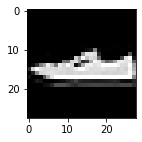

In [6]:
random.seed(28)
i = random.randint(1,len(X_train))
plt.figure(figsize=(2,2))
plt.imshow(X_train[i] , cmap = 'gray')
plt.show()

Podemos ver que se ha cargado un zapato. Asimismo, podemos comprobar que el tamaño de la imagen es (28,28):

In [7]:
X_train[i].shape

(28, 28)

De acuerdo con la imagen de arriba, esperamos que la etiqueta de esta foto sea 7 (Sneaker):

In [8]:
print('El label de la figura es:', y_train[i])

El label de la figura es: 7


Con el fin de facilitar el entendimiento de nuestro conjunto de datos, mapeemos la etiqueta de clase con el nombre de artículo de vestimenta relacionado, de acuerdo con la figura (1):

In [9]:
map_etiquetas = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

Con esto, ya podemos visualizar algunas imágenes más de nuestro conjunto de datos y ver que los nombres (etiquetas) corresponden con el objeto mostrado:

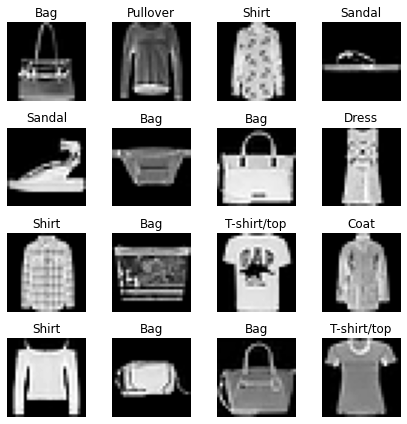

In [10]:
fig, axes = plt.subplots(4, 4, figsize = (6,6))
for row in axes:
    for axe in row:
        indice =  random.randint(0,len(X_train))
        axe.imshow(X_train[indice], cmap='gray')
        axe.set_title(map_etiquetas[y_train[indice]])
        axe.set_axis_off()
        
plt.tight_layout()

Finalmente, revisemos la distribución de clases:

In [11]:
unicos, cantidad = np.unique(y_train, return_counts=True)
frecuencias = np.asarray((unicos, cantidad)).T
print(frecuencias)

[[   0 4817]
 [   1 4819]
 [   2 4790]
 [   3 4780]
 [   4 4788]
 [   5 4850]
 [   6 4784]
 [   7 4743]
 [   8 4801]
 [   9 4828]]


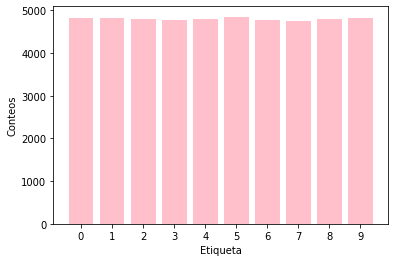

In [12]:
plt.bar(np.arange(len(frecuencias)), frecuencias[:,1],color='pink')
plt.xticks(unicos)
plt.xlabel('Etiqueta')
plt.ylabel('Conteos')
plt.show()

Podemos ver que el conjunto de entrenamiento está aproximadamente balanceado: no hay necesidad de hacer _oversampling_ ni _subsampling_ ni considerar pesos en el entrenamiento.

## 1.2 Perfilamiento y entendimiento de los datos 
Los valores de los pixeles usualmente se almacenan como números enteros en un rango entre 0 y 255. Con el fin de asegurar $\mu = 0$ y $\sigma^2 = 1$, hacemos una normalización (reescalamiento) para que las imágenes queden en el rango de 0 a 1. También transformamos la variable objetivo, que en este momento es un vector numérico con diez niveles, a "categorical", es decir _one-hot-encoding_, que en nuestra experiencia funciona mejor para tareas de clasificación multiclase con redes neuronales artificiales.

In [13]:
X_train = X_train/255
X_val = X_val/255

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

Vemos que esto no afecta la construcción de la imagen. Es exactamente igual a la que obtuvimos al inicio.

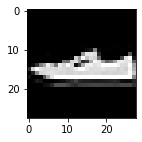

In [14]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[i] , cmap = 'gray')
plt.show()

## 1.3 Modelamiento
### 1.3.1 Entrenamiento de un perceptrón multicapa
El primer modelo que entrenaremos será un perceptrón multicapa. Tenemos varias opciones para implementarlo, dos de ellas son las más interesantes. Primero, como en el laboratorio pasado, podríamos aplanar la imagen y pasarla como input a la red. La segunda opción es utilizar primero algunas capas convolucionales, las cuales han demostrado un gran desempeño en aplicaciones con imágenes [2]. En este ocasión, usaremos esta segunda opción:

Como siempre, primero planteamos un modelo base, cuyos hiperparámetros ajustamos después.

#### 1.3.1.1 Modelo inicial

El modelo inicial, que será nuestro baseline, se conformará de dos partes: el front-end de extracción de características compuesto por capas convolucionales y de pooling, y el back-end clasificador que hará una predicción.

Consideremos primero un modelo con una sola capa convolucional, con un tamaño de kernel pequeño (3,3) y una cantidad modesta de filtros (32 en este caso, usualmente se acostumbra poner entre 32 y 512 filtros por capa), que utiliza <code>padding='same'</code> seguida de una capa de max pooling, que hará un pooling (2,2) en línea con las prácticas comunes [3]. Añadimos posteriormente una capa de aplanamiento, con el fin de pasarle los _features_ a las capas densas. Para nuestro modelo baseline, consideramos únicamente una capa densa de 256 neuronas. Realmente, esta cantidad de neuronas es una decisión un poco arbitraria. Un _rule of thumb_ (_naïve_) de calcular el número de neuronas de la primera capa oculta es que sea menos del doble de las de la capa de entrada [5]. No obstante, esas serían muchísimas neuronas en nuestro caso (pues la entrada de la primer capa densa es la imagen aplanada, después de pasar por la capa convolucional y maxpooling: $14 \times 14 \times 32 = 6272$, donde 32 es el número de filtros). Por lo tanto, seguramente caeríamos en _overfitting_ y con un costo computacional inmenso. Tomamos 256 neuronas pues no son muy pocas, de manera que pudiera caer en _underfitting_, pero tampoco un número excesivo sino manejable. No obstante, este es un hiperparámetro que deberemos ajustar más adelante. Para nuestro primer modelo _naïve_, utilizamos una única capa oculta. Esto es porque estamos intentando crear un modelo simple. No obstante, este será otro de los hiperparámetros que ajustaremos.

Asimismo, antes de la capa de aplanamiento y después de la capa densa de 256 neuronas, ponemos una capa de dropout. Esto lo hacemos con fines de regularización de nuestro modelo. La máxima regularización corresponde a $p = 0.5$. Esta es la que utilizaremos para la segunda capa dropout (i.e. después de la capa densa de 128 neuronas). La primera considerará un valor de 0.3, pues no queremos limitar tanto el aprendizaje en las capas convolucionales. Esto también lo ajustaremos como hiperparámetro, pero lo consideramos un buen punto de partida para el primer modelo [6].

Ahora, todas nuestras capas utilizan ReLu como función de activación. De acuerdo con la literatura, la función ReLu es la más utilizada en aplicaciones de Machine Learning. En la práctica, además, tiende a tener mejor convergencia que la sigmoide o la tanh [3]. Asimismo, la función de activación ReLu es la que corre en el menor tiempo de cómputo (es menos costoso calcular $\max(0,a)$, donde a es la entrada de la neurona, que calcular, por ejemplo $(1+e^{-a})^{-1}$, para la logística). Por último, en varias aplicaciones y artículos, se ha visto que ReLu se desempeña muy bien en casi todos los casos. Y cuando se encuentran otras con mejor desempeño, la mejoría es casi despreciable [4]. Por lo tanto, en general (y sobre todo para problemas complejos como este) no vale la pena buscar una función de activación diferente. También utilizamos el esquema de inicialización de pesos He, con <code>he_uniform</code> pues se considera buena práctica [5].

Finalmente, tenemos la capa de salida: compuesta por 10 neuronas (pues tenemos 10 clases), con función de activación softmax. Esta se usa con frecuencia en clasificación multiclase, por lo que es una decisión completamente adecuada para la salida de nuestra red. 



In [17]:
output = 10 # pues tenemos 10 clases
# Inicializamos el modelo
baseline_MLP = Sequential(name='Baseline_MLP') 
# Agregamos una capa convolucional con 32 filtros, con un kernel pequenio, funcion de activacion relu e 
# inicializador he_uniform. Especificamos tambien las dimensiones de la entrada (28,28,1) donde el 1 significa
# que esta en escala de grises.
baseline_MLP.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                        input_shape=(28, 28, 1), padding='same'))
# Capa de max pooling de tamanio de pool 2x2.
baseline_MLP.add(MaxPooling2D((2, 2)))
# Definimos la tasa de dropout para la parte convolucional
baseline_MLP.add(Dropout(0.3))
# Ponemos la capa de aplanamiento, para crear la capa densa
baseline_MLP.add(Flatten())
# Creamos la capa densa, de 256 neuronas, con funcion de activacion relu y kernel de inicializacion he_uniform
baseline_MLP.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# Definimos la tasa de dropout para la parte MLP
baseline_MLP.add(Dropout(0.5))
# Definimos la capa de salida, con funcion de activacion softmax, y 10 neuronas pues tenemos 10 clases
baseline_MLP.add(Dense(10, activation='softmax'))

Ahora sí, veamos la arquitectura en resumen:

In [18]:
baseline_MLP.summary()

Model: "Baseline_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               


Ahora, debemos elegir una métrica, una función de pérdida y un optimizador. En cuanto a la función de pérdida, la que se usa con frecuencia en problemas de clasificación es la de entropía cruzada. De hecho, se recomienda no cambiarla, a menos de que se tenga una razón lo suficientemente fuerte para hacerlo, pues es la función de pérdida preferida en el marco de la máxima verosimilitud. Para problemas multiclase, donde se tiene OneHotEncoding, se utiliza entropía cruzada categórica: categorical_crossentropy [7].

En el caso del optimizador, elegimos adam. Por lo general, este es el que mejores resultados presenta, de acuerdo con la literatura, con el valor por defecto de tasa de aprendizaje de 0.001. Asimismo, nos quitamos de encima el ajustar un hiperparámetro extra (la tasa de aprendizaje), pues los algoritmos adaptativos como Adam van ajustando esta tasa a medida que entrenan [8]. Últimamente se ha visto que SGD, acompañado de un buen learning rate, puede arrojar resultados excelentes también. No obstante, esto implica el ajuste fino de un hiperparámetro más que, dada la complejidad del problema, puede ser muy costosa computacionalmente.

Asimismo, debemos definir la métrica que informa el progreso del modelo. En este caso elegimos la exactitud (accuracy) como métrica, pues el usuario aspira poder diagnosticar de forma amplia sobre las diez categorías. En consecuencia, tiene más sentido utilizar una métrica que reporte el éxito general del modelo sin privilegiar una categoría sobre otra.

In [19]:
baseline_MLP.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Control de la complejidad y los tiempos de procesamiento**

Una forma de controlar la complejidad y los tiempos de procesamiento es mediante el uso de callbacks. Estas son acciones durante las etapas del entrenamiento.

De acuerdo con la documentación de Tensorflow, encontramos dos callbacks que consideramos útiles para esta familia de problemas. Primero consideramos EarlyStopping. En este caso, ponemos la cantidad monitoreada como la medida que tomamos a la pérdida (loss) tal que, si después de 3 épocas no ha mejorado, entonces pare el entrenamiento y la actualización de los pesos.

El otro callback que utilizaremos es TensorBoard. Este permite visualizar un reporte del entrenamiento, el cual nos será útil para concluir sobre el avance del modelo en función de los diferentes ciclos de aprendizaje.

In [20]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None,)
callbacks = [early_stopping,tensorboard_callback]

In [21]:
history_mlp_baseline = baseline_MLP.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=20, batch_size=200, callbacks=callbacks,
                    validation_data=(
                    X_val.reshape(-1, 28, 28, 1), 
                    y_val
                    ))


Epoch 1/20
240/240 [==============================] - 15s 59ms/step - loss: 0.5791 - accuracy: 0.7958 - val_loss: 0.3528 - val_accuracy: 0.8718
Epoch 2/20
240/240 [==============================] - 14s 60ms/step - loss: 0.3858 - accuracy: 0.8615 - val_loss: 0.3103 - val_accuracy: 0.8859
Epoch 3/20
240/240 [==============================] - 15s 63ms/step - loss: 0.3318 - accuracy: 0.8792 - val_loss: 0.2814 - val_accuracy: 0.8972
Epoch 4/20
240/240 [==============================] - 15s 63ms/step - loss: 0.3002 - accuracy: 0.8915 - val_loss: 0.2661 - val_accuracy: 0.8997
Epoch 5/20
240/240 [==============================] - 15s 63ms/step - loss: 0.2796 - accuracy: 0.8988 - val_loss: 0.2583 - val_accuracy: 0.9047
Epoch 6/20
240/240 [==============================] - 14s 60ms/step - loss: 0.2636 - accuracy: 0.9036 - val_loss: 0.2498 - val_accuracy: 0.9064
Epoch 7/20
240/240 [==============================] - 13s 54ms/step - loss: 0.2480 - accuracy: 0.9086 - val_loss: 0.2460 - val_accuracy:

In [29]:
# %tensorboard --logdir logs/fit

<img src='first_esta_si.png'/>

Los reportes de _Tensorboard_ nos muestran mejoras progresivas durante el entrenamiento, y, aunque la curva sugiere que la red aún podría mejorar la exactitud en el conjunto de entrenamiento, pareciera que ya está llegando a una meseta en el conjunto de validación. Aumentar el rendimiento mucho más allá de este punto probablemente resultaría en overfitting. 

----
#### 1.3.1.2 Modelo MLP con búsqueda de hiperparámetros

Ahora, queremos realizar la búsqueda de _algunos_ hiperparámetros para nuestro modelo. Decimos _algunos_ pues buscar todos los del espacio de hiperparámetros es prácticamente imposible con el poder de cómputo con el que contamos. 

Hay muchos hiperparámetros por afinar en el modelo que en principio podríamos seguir buscando mediante la función de GridSearch. Sin embargo, no es recomendable pues nos encontramos en un universo enorme de hiperparámetros si deseamos hacer una búsqueda exhaustiva.

Por ello construimos una función que nos permita especificar la Red Neuronal esperada y utilizamos la función RandomizedSearchCV, que no hace una búsqueda exhaustiva sino aleatoria sobre algunas configuraciones del espacio de hiperparámetros, lo que es mucho más eficiente en términos de tiempo y poder computacional demandado.

Los parámetros que son más importantes de ajustar son el número de neuronas por capa, el número total de capas y la tasa de dropout. Note que también podríamos ajustar los hiperparámetros de las capas convolucionales. No obstante, como no hemos visto esto aún en clase, dejamos los que teníamos para nuestro modelo inicial. Definimos entonces una función que nos permita hacer esto a continuación:

In [30]:
def entrenar_red(nn1=256, nn2=256, n_layers= 3, dropout_conv = 0.1, dropout_dense=0.5):
    output = 10 # Tenemos 10 neuronas pues son las 10 clases de salida
    clf = Sequential(name='MLP_CV')
    clf.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                        input_shape=(28, 28, 1), padding='same'))
    # Capa de max pooling de tamanio de pool 2x2.
    clf.add(MaxPooling2D((2, 2)))
    # Capa de dropout tras convolución, con hiperparámetro a ajustar
    clf.add(Dropout(dropout_conv, name='Dropout_conv_{0}'.format(dropout_conv))) # Dropout conv
    clf.add(Flatten())
    first = True

    for i in range(n_layers):
        if i == 0:
            clf.add(Dense(nn1, activation='relu', name='Capa_Oculta_{0}'.format(i))) # num neuronas capa 1
            first = False
        else:
            clf.add(Dense(nn2, activation='relu', name = 'Capa_Oculta_{0}'.format(i))) # num neuronas capa 2 y 3

            
    
    clf.add(Dropout(dropout_dense,name='Dropout_dense_{0}'.format(dropout_dense))) # Dropout (parecido a regularizacion)
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida')) # Capa de salidad

    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Valores por defecto
    
    return clf

# Modelo que utiliza el GridSearch
modelCV_mlp = KerasClassifier(build_fn=entrenar_red, epochs=20, batch_size=500,verbose=1) # Modelo esqueleto

De acuerdo con nuestro código, la segunda y la tercera capa (cuando haya) siempre tendrán nn2 neuronas. Hacemos esto para que no aumentar el espacio de búsqueda de hiperparámetros.

Debemos generar una métrica propia para la accuracy, para que la CV funcione bien y no haya problema con las dimensionalidad de y_true y y_pred:


In [31]:
def my_custom_loss_func(y_true, y_pred):
    return accuracy_score(y_true.argmax(1), y_pred.flatten())

In [32]:
pipe_1 = Pipeline([('best_MLP', modelCV_mlp)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  best_MLP__nn1 = [64,128,256],
                  best_MLP__nn2 = [64,128,256],
                  best_MLP__n_layers = [1,2,3],
                  best_MLP__dropout_conv = [0.1,0.25,0.5],
                  best_MLP__dropout_dense = [0.1,0.25,0.5]
                  )

# Definimos la metrica 
score = make_scorer(my_custom_loss_func, greater_is_better=True)

# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
grid = RandomizedSearchCV(pipe_1, param_grid, scoring=score, verbose=3, cv=3, n_iter=10, random_state=28)

Antes de correr, unimos los conjuntos de entrenamiento y validación para hacer la validación cruzada.

In [33]:
X_joined_train = np.array(list(X_train) + list(X_val))
y_joined_train = np.array(list(y_train) + list(y_val))

In [25]:
grid.fit(X_joined_train.reshape(-1, 28, 28, 1), y_joined_train, best_MLP__callbacks=callbacks)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
80/80 [==============================] - 9s 110ms/step - loss: 0.6374 - accuracy: 0.7762
Epoch 2/20
80/80 [==============================] - 9s 113ms/step - loss: 0.3485 - accuracy: 0.8759
Epoch 3/20
80/80 [==============================] - 8s 101ms/step - loss: 0.2948 - accuracy: 0.8929
Epoch 4/20
80/80 [==============================] - 8s 100ms/step - loss: 0.2611 - accuracy: 0.9060
Epoch 5/20
80/80 [==============================] - 8s 106ms/step - loss: 0.2370 - accuracy: 0.9116
Epoch 6/20
80/80 [==============================] - 8s 98ms/step - loss: 0.2136 - accuracy: 0.9204
Epoch 7/20
80/80 [==============================] - 8s 96ms/step - loss: 0.1904 - accuracy: 0.9300
Epoch 8/20
80/80 [==============================] - 8s 96ms/step - loss: 0.1774 - accuracy: 0.9334
Epoch 9/20
80/80 [==============================] - 8s 96ms/step - loss: 0.1630 - accuracy: 0.9391
Epoch 10/20
80/80 [========================

80/80 [==============================] - 9s 111ms/step - loss: 0.4103 - accuracy: 0.8516
Epoch 13/20
80/80 [==============================] - 9s 115ms/step - loss: 0.4029 - accuracy: 0.8546
Epoch 14/20
80/80 [==============================] - 9s 116ms/step - loss: 0.3966 - accuracy: 0.8558
Epoch 15/20
80/80 [==============================] - 9s 113ms/step - loss: 0.3885 - accuracy: 0.8587
Epoch 16/20
80/80 [==============================] - 9s 111ms/step - loss: 0.3843 - accuracy: 0.8599
Epoch 17/20
80/80 [==============================] - 9s 112ms/step - loss: 0.3771 - accuracy: 0.8620
Epoch 18/20
80/80 [==============================] - 9s 112ms/step - loss: 0.3660 - accuracy: 0.8665
Epoch 19/20
80/80 [==============================] - 9s 113ms/step - loss: 0.3611 - accuracy: 0.8681
Epoch 20/20
80/80 [==============================] - 9s 115ms/step - loss: 0.3619 - accuracy: 0.8678
[CV 2/3] END best_MLP__dropout_conv=0.5, best_MLP__dropout_dense=0.5, best_MLP__n_layers=1, best_MLP__n

80/80 [==============================] - 8s 100ms/step - loss: 0.4480 - accuracy: 0.8436
Epoch 3/20
80/80 [==============================] - 8s 99ms/step - loss: 0.3763 - accuracy: 0.8664
Epoch 4/20
80/80 [==============================] - 8s 98ms/step - loss: 0.3363 - accuracy: 0.8792
Epoch 5/20
80/80 [==============================] - 8s 98ms/step - loss: 0.3023 - accuracy: 0.8938
Epoch 6/20
80/80 [==============================] - 8s 98ms/step - loss: 0.2871 - accuracy: 0.8974
Epoch 7/20
80/80 [==============================] - 8s 99ms/step - loss: 0.2680 - accuracy: 0.9046
Epoch 8/20
80/80 [==============================] - 8s 99ms/step - loss: 0.2563 - accuracy: 0.9072
Epoch 9/20
80/80 [==============================] - 8s 99ms/step - loss: 0.2415 - accuracy: 0.9112
Epoch 10/20
80/80 [==============================] - 8s 98ms/step - loss: 0.2291 - accuracy: 0.9161
Epoch 11/20
80/80 [==============================] - 8s 102ms/step - loss: 0.2202 - accuracy: 0.9197
Epoch 12/20
80/80

80/80 [==============================] - 8s 103ms/step - loss: 0.1817 - accuracy: 0.9320
Epoch 20/20
80/80 [==============================] - 8s 102ms/step - loss: 0.1778 - accuracy: 0.9331
[CV 1/3] END best_MLP__dropout_conv=0.1, best_MLP__dropout_dense=0.5, best_MLP__n_layers=1, best_MLP__nn1=256, best_MLP__nn2=128;, score=0.918 total time= 2.8min
Epoch 1/20
80/80 [==============================] - 9s 105ms/step - loss: 0.7032 - accuracy: 0.7527
Epoch 2/20
80/80 [==============================] - 8s 101ms/step - loss: 0.4222 - accuracy: 0.8493
Epoch 3/20
80/80 [==============================] - 8s 100ms/step - loss: 0.3682 - accuracy: 0.8700
Epoch 4/20
80/80 [==============================] - 8s 99ms/step - loss: 0.3334 - accuracy: 0.8812
Epoch 5/20
80/80 [==============================] - 8s 104ms/step - loss: 0.3114 - accuracy: 0.8887
Epoch 6/20
80/80 [==============================] - 8s 100ms/step - loss: 0.2913 - accuracy: 0.8934
Epoch 7/20
80/80 [==============================]

80/80 [==============================] - 8s 102ms/step - loss: 0.2408 - accuracy: 0.9103
Epoch 10/20
80/80 [==============================] - 8s 103ms/step - loss: 0.2311 - accuracy: 0.9134
Epoch 11/20
80/80 [==============================] - 8s 102ms/step - loss: 0.2209 - accuracy: 0.9179
Epoch 12/20
80/80 [==============================] - 8s 103ms/step - loss: 0.2172 - accuracy: 0.9191
Epoch 13/20
80/80 [==============================] - 9s 107ms/step - loss: 0.2064 - accuracy: 0.9244
Epoch 14/20
80/80 [==============================] - 8s 103ms/step - loss: 0.1974 - accuracy: 0.9269
Epoch 15/20
80/80 [==============================] - 8s 103ms/step - loss: 0.1920 - accuracy: 0.9294
Epoch 16/20
80/80 [==============================] - 8s 104ms/step - loss: 0.1848 - accuracy: 0.9314
Epoch 17/20
80/80 [==============================] - 8s 104ms/step - loss: 0.1803 - accuracy: 0.9327
Epoch 18/20
80/80 [==============================] - 8s 103ms/step - loss: 0.1755 - accuracy: 0.9341
Ep

120/120 [==============================] - 11s 95ms/step - loss: 0.2917 - accuracy: 0.8936
Epoch 5/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2728 - accuracy: 0.8994
Epoch 6/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2570 - accuracy: 0.9047
Epoch 7/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2446 - accuracy: 0.9101
Epoch 8/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2332 - accuracy: 0.9134
Epoch 9/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2232 - accuracy: 0.9179
Epoch 10/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2156 - accuracy: 0.9197
Epoch 11/20
120/120 [==============================] - 11s 94ms/step - loss: 0.2054 - accuracy: 0.9235
Epoch 12/20
120/120 [==============================] - 11s 94ms/step - loss: 0.1956 - accuracy: 0.9276
Epoch 13/20
120/120 [==============================] - 11s 95ms/step - loss: 0.1926 - accu

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('best_MLP',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc7d4db6df0>)]),
                   param_distributions={'best_MLP__dropout_conv': [0.1, 0.25,
                                                                   0.5],
                                        'best_MLP__dropout_dense': [0.1, 0.25,
                                                                    0.5],
                                        'best_MLP__n_layers': [1, 2, 3],
                                        'best_MLP__nn1': [64, 128, 256],
                                        'best_MLP__nn2': [64, 128, 256]},
                   random_state=28, scoring=make_scorer(my_custom_loss_func),
                   verbose=3)

In [26]:
best_model_mlp = grid.best_estimator_
best_model_mlp['best_MLP'].model.summary()

Model: "MLP_CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
Dropout_conv_0.5 (Dropout)   (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 6272)              0         
_________________________________________________________________
Capa_Oculta_0 (Dense)        (None, 128)               802944    
_________________________________________________________________
Dropout_dense_0.1 (Dropout)  (None, 128)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 10)                1290 

In [27]:
best_score_mlp = grid.best_score_
print('La accuracy del mejor modelo para MLP es: ', best_score_mlp)

La accuracy del mejor modelo para MLP es:  0.9192


Curiosamente, el mejor modelo fue con una sola capa de 128 neuronas, pero con más regularización en la convolución que en la capa densa, como habíamos puesto inicialmente. De todas formas, al observar detenidamente, el desempeño de todos fue bastante aproximado en todos los casos (en algunos hacía overfitting). Esto quiere decir que, para este caso, todos los hiperparámetros dan un modelo bastante cercano al baseline. Quizá, para aumentar la accuracy, podríamos usar más filtros (y/o) capas convolucionales. No obstante, eso se sale del enfoque de este laboratorio. De hecho, cabe aclarar que encontramos un ejemplo en el que usaban más capas convolucionales y les daba aproximadamente la misma exactitud [9].

In [28]:
# Podemos ver que los 10 modelos probados arrojaron scores similares.
grid.cv_results_['mean_test_score']

array([0.9136    , 0.9192    , 0.90365   , 0.91561667, 0.91398333,
       0.91456667, 0.91621667, 0.90936667, 0.91911667, 0.91563333])

En realidad, como nos muestra el reporte, los resultados aquí fueron muy similares. Esto sugeriría que, si quisiéramos mejorar mucho el rendimiento de esta familia de modelos, necesitaríamos explorar otras regiones en la búsqueda de hiperparámetros, sea en los valores o buscando de plano otros hiperparámetros que no exploramos aquí.

Finalmente, el último modelo que queremos estudiar es una de las arquitecturas vistas en clase: LeNet. A esta no le haremos ajuste de hiperparámetros. Solamente queremos ver su comportamiento en comparación con los otros dos modelos que ya construimos, pues nos pareció interesante ahora que lo estudiamos. De esta forma, siguiendo la arquitectura sugerida por LeCun [10],

In [55]:
lenet = Sequential(name='LeNet')

lenet.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
lenet.add(AveragePooling2D())
lenet.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
lenet.add(AveragePooling2D())
lenet.add(Flatten())
lenet.add(Dense(units=120, activation='relu'))
lenet.add(Dense(units=84, activation='relu'))
lenet.add(Dense(units=10, activation = 'softmax'))

Note que este modelo no contempla el uso de capas de Dropout. Asimismo, no usa MaxPooling sino AveragePooling en su lugar. Cuenta con dos capas convolucionales (en lugar de una, como en nuestro modelo anterior), así como con dos capas de Average Pooling. Tenemos dos capas densas, en lugar de una, pero de 120 y 84 neuronas, que son más menos que las que consideramos previamente.

In [56]:
lenet.summary()

Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               192120    
_________________________________________________________________
dense_5 (Dense)              (None, 84)                10164 

Usamos el mismo optimizador, función de pérdida y métrica anteriormente utilizadas:

In [57]:
lenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Hacemos el fit, usando los callbacks que definimos previamente:

In [58]:
history_lenet = lenet.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=20, batch_size=200, callbacks=callbacks,
                    validation_data=(
                    X_val.reshape(-1, 28, 28, 1), 
                    y_val
                    ))

Epoch 1/20
240/240 [==============================] - 12s 51ms/step - loss: 0.7369 - accuracy: 0.7268 - val_loss: 0.5117 - val_accuracy: 0.8090
Epoch 2/20
240/240 [==============================] - 12s 49ms/step - loss: 0.4671 - accuracy: 0.8287 - val_loss: 0.4255 - val_accuracy: 0.8468
Epoch 3/20
240/240 [==============================] - 12s 49ms/step - loss: 0.4043 - accuracy: 0.8535 - val_loss: 0.3951 - val_accuracy: 0.8532
Epoch 4/20
240/240 [==============================] - 12s 49ms/step - loss: 0.3692 - accuracy: 0.8645 - val_loss: 0.3644 - val_accuracy: 0.8698
Epoch 5/20
240/240 [==============================] - 12s 50ms/step - loss: 0.3388 - accuracy: 0.8776 - val_loss: 0.3574 - val_accuracy: 0.8672
Epoch 6/20
240/240 [==============================] - 12s 50ms/step - loss: 0.3209 - accuracy: 0.8831 - val_loss: 0.3372 - val_accuracy: 0.8768
Epoch 7/20
240/240 [==============================] - 12s 49ms/step - loss: 0.3021 - accuracy: 0.8895 - val_loss: 0.3332 - val_accuracy:

In [59]:
# %tensorboard --logdir logs/fit

<img src='lenet.png'/>


Este modelo base sin búsqueda de hiperparámetros tiene un comportamiento muy similar a los anteriores. La curva del _loss function_ sugiere que podría mejorar un poco (pero no _mucho_ más) con algunos ciclos adicionales de entrenamiento, pero habría que tener cuidado con que pueda hacer sobreajuste sobre el conjunto de entrenamiento.

### 1.3.2 Autoencoder para reducción de dimensionalidad y MLP

Los codificadores automáticos o autoencoders se utilizan para el preentrenamiento de otras redes, reducción de la dimensionalidad, aprendizaje de espacios latentes, entre otros.

Los autoencoders, por otro lado, pueden ser entrenados sin supervisión. Su estructura generalmente se caracteriza por:

1. La cantidad de neuronas ocultas es menor que la cantidad de celdas de entrada.
2. La cantidad de celdas de salida es igual a la cantidad de celdas de entrada.
3. El autoencoder se entrena de manera en que la salida está lo más cerca posible de la entrada, obligando a los autoencoders a generalizar datos y realizar búsqueda de patrones comunes.

#### 1.3.2.1 Modelo autoencoder
Empezamos con el modelo de autoencoder que usamos en el laboratorio. Note que todo está compuesto de capas convolucionales. En realidad, estas capas no han sido del todo cubiertas en el curso, por lo que hay muchos hiperparámetros que todavía no sabemos ajustar bien. Por lo tanto, en este caso (si logramos ver que el autoencoder, con este modelo, reconstruye adecuadamente las imágenes) nos quedaremos únicamente con este, sin realizar validación cruzada ni búsqueda de hiperparámetros. Para el que sí haremos será el MLP que haremos más adelante.

Para las capas convolucionales, note lo siguiente:

El tamaño del kernel es el mismo del MLP diseñado previamente. Asimismo, por buenas prácticas, dejamos <code>padding='same'</code>. El encoder se compone de dos capas: una convolucional de 16 filtros y, la segunda, de 8 filtros. La capa que le sigue es hasta la que usaremos como input del MLP. En esta, en lugar de tener <code>strides=2</code>, tenemos <code>strides=1</code>. Finalmente, el decoder usa dos capas convolucionales transpuestas (i.e. las que se usan para decodificar). La última tiene función de activación sigmoide pues queremos los valores de los pixeles entre 0 y 1.



In [60]:
autoencoder = Sequential(name="Autoencoder")

# Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

Debido a que tenemos un encoder, usamos como función de pérdida el error cuadrático medio y, como optimizador, usamos Adam, el mejor de todos usualmente, según la literatura que hemos estudiado [8]. Note que el _learning rate_ por defecto de Adam es 0.001.

In [61]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


Ahora, hacemos fit al autoencoder, usando los callbacks que definimos previamente:

In [62]:
history_autoencoder = autoencoder.fit(X_train.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=20, 
                batch_size=200, 
                callbacks = [callbacks],
                validation_data=(
                    X_val.reshape(-1, 28, 28, 1), 
                    X_val.reshape(-1, 28, 28, 1)
                    )
                )

Epoch 1/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0502 - val_loss: 0.0184
Epoch 2/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0152 - val_loss: 0.0128
Epoch 3/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 4/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 5/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 6/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 7/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 8/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 10/20
240/240 [==============================] - 5s 21ms/step - loss: 0.0054 - val_lo

In [63]:
# %tensorboard --logdir logs/fit

<img src='second.png'/>

Con este autoencoder, podemos hacer la predicción de nuestras imágenes. En este caso, tomaremos únicamente las 10 primeras con el fin de revisar que ellas estén bien reconstruidas (por lo menos en validación, como hicimos en clase). Si está bien, podemos justificar el uso de la capa intermedia que previamente mencionamos como el input de la MLP. Entonces,

In [64]:
predichas_autoencoder = autoencoder.predict(X_val[:10].reshape(-1, 28, 28, 1))

In [65]:
evaluation_autoencoder = autoencoder.evaluate(X_val.reshape(-1, 28, 28, 1), X_val.reshape(-1, 28, 28, 1))
print('Validation Loss : {:.3f}'.format(evaluation_autoencoder))

375/375 [==============================] - 1s 2ms/step - loss: 0.0041
Validation Loss : 0.004


Vemos que la pérdida en validación es realmente baja, lo cual da buenos indicios de nuestro modelo. Veamos si las imágenes están bien reconstruidas:

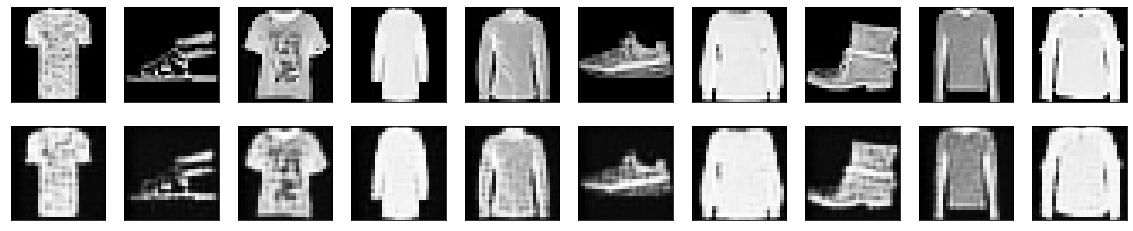

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_val[:10], predichas_autoencoder], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Podemos ver que, en efecto, ¡el autoencoder ha hecho un gran trabajo reconstruyendo las imágenes! Usemos entonces hasta la capa de la mitad para crear nuestro MLP. Lo que haremos es usar el autoencoder como una herramienta de reducción de dimensionalidad y construir un MLP sobre el espacio latnte. En teoría, deberíamos tener mejores resultados que solamente con el MLP.
<img src='autoencoders.png'/>

Imagen tomada de: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

#### 1.3.2.2 Modelo MLP baseline

Para este, debemos definir la cantidad de capas densas que tendrá, pero antes agregamos una capa para aplanar la imagen. Como este es un modelo baseline, podemos tomar una única capa. Como tomamos menos del doble de las de la capa de entrada, y para evitar hacer overfitting, escogemos únicamente 256 neuronas en esta capa. Por las razones expuestas para el primer MLP, usamos la misma función de activación, ReLu. Tanto el número de capas como la cantidad de neuronas en cada una, será un hiperparámetro que ajustaremos despuñes.

Seguido de esto, añadimos una capa de Dropout por la regularización. Consideramos p=0.5 que es la máxima, pero este es un hiperparámetro que debemos ajustar.

Finalmente, ponemos una capa de salida con 10 neuronas, pues tenemos 10 clases. Como dijimos atrás, la función de activación de esta capa es softmax.

In [67]:
mlp_autoencoder = Sequential(name='MLP_post_autoencoder')
# Agregamos hasta la tercera capa del autoencoder a nuestro MLP
mlp_autoencoder.add(autoencoder.layers[0])
mlp_autoencoder.add(autoencoder.layers[1])
mlp_autoencoder.add(autoencoder.layers[2])
# Agregamos una capa para aplanar la imagen y dársela al MLP.
mlp_autoencoder.add(Flatten())
# Agregamos una capa densa de 256 neuronas con función de activación relu
mlp_autoencoder.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# Agregamos una capa de regularización con p=0.5 (i.e. máxima regularización)
mlp_autoencoder.add(Dropout(0.5))
# Agregamos la capa de salida
mlp_autoencoder.add(Dense(10, activation='softmax'))

Veamos cómo va nuestro modelo:

In [68]:
mlp_autoencoder.summary()

Model: "MLP_post_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_9 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               100608    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)       

Ahora, debemos elegir una métrica, una función de pérdida y un optimizador. En cuanto a la función de pérdida, la que se usa con frecuencia en problemas de clasificación es la de entropía cruzada. De hecho, se recomienda no cambiarla, a menos de que se tenga una razón lo suficientemente fuerte para hacerlo, pues es la función de pérdida preferida en el marco de la máxima verosimilitud. Para problemas multiclase, donde se tiene OneHotEncoding, se utiliza entropía cruzada categórica: categorical_crossentropy [7].

En el caso del optimizador, elegimos adam. Por lo general, este es el que mejores resultados presenta, de acuerdo con la literatura, con el valor por defecto de tasa de aprendizaje de 0.001. Asimismo, evitamos ajustar un hiperparámetro extra (la tasa de aprendizaje), pues los algoritmos adaptativos como Adam van cambiando esta tasa a medida que entrenan [8]. Últimamente se ha visto que SGD, acompañado de un buen learning rate, puede arrojar resultados excelentes también. No obstante, esto implica el ajuste de un hiperparámetro que, dada la complejidad del problema, puede ser muy costosa computacionalmente.

Asimismo, debemos definir la métrica que informa el éxito del modelo. En este caso elegimos la exactitud (accuracy) como métrica, pues el usuario aspira poder diagnosticar de forma amplia sobre las diez categorías. En consecuencia, tiene más sentido utilizar una métrica que reporte el éxito general del modelo sin privilegiar una categoría sobre otra.

In [69]:
mlp_autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Usando los mismos callbacks de siempre, obtenemos que:

In [70]:
history_mlp_autoencoder = mlp_autoencoder.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=20, batch_size=200, callbacks=callbacks,
                    validation_data=(
                    X_val.reshape(-1, 28, 28, 1), 
                    y_val
                    ))

Epoch 1/20
240/240 [==============================] - 3s 12ms/step - loss: 0.6875 - accuracy: 0.7620 - val_loss: 0.4293 - val_accuracy: 0.8418
Epoch 2/20
240/240 [==============================] - 3s 11ms/step - loss: 0.4442 - accuracy: 0.8409 - val_loss: 0.3879 - val_accuracy: 0.8597
Epoch 3/20
240/240 [==============================] - 3s 12ms/step - loss: 0.3950 - accuracy: 0.8587 - val_loss: 0.3553 - val_accuracy: 0.8733
Epoch 4/20
240/240 [==============================] - 3s 11ms/step - loss: 0.3701 - accuracy: 0.8667 - val_loss: 0.3399 - val_accuracy: 0.8771
Epoch 5/20
240/240 [==============================] - 3s 11ms/step - loss: 0.3445 - accuracy: 0.8746 - val_loss: 0.3319 - val_accuracy: 0.8809
Epoch 6/20
240/240 [==============================] - 3s 11ms/step - loss: 0.3332 - accuracy: 0.8776 - val_loss: 0.3259 - val_accuracy: 0.8833
Epoch 7/20
240/240 [==============================] - 3s 11ms/step - loss: 0.3187 - accuracy: 0.8839 - val_loss: 0.3182 - val_accuracy: 0.8857

In [71]:
# %tensorboard --logdir logs/fit

<img src='third.png'/>

Para nuestra sorpresa, este modelo tiene un rendimiento inferior a los modelos observados previamente. En particular, aunque pareciera que todavía hay espacio para que el modelo mejorara la clasificación de la clase de entrenamiento, las curvas sugieren que se entraría rápidamente en el territorio del sobreajuste. Así las cosas, habría que hacer mayor uso de regularización o diminuir la complejidad del modelo de alguna otra manera.

----
Intentamos ahora ajustar hiperparámetros a ver si logramos una mejor exactitud.

Hay muchos hiperparámetros por afinar en el modelo que en principio podríamos seguir buscando mediante la función de GridSearch. Sin embargo, no es recomendable pues nos encontramos en un universo enorme de hiperparámetros si deseamos hacer una búsqueda exhaustiva.

Por ello construimos una función que nos permita especificar la Red Neuronal esperada y utilizamos la función RandomizedSearchCV, que no hace una búsqueda exhaustiva sino aleatoria sobre algunas configuraciones del espacio de hiperparámetros, lo que es mucho más eficiente en términos de tiempo y poder computacional demandado.

Claramente, lo ideal sería ajustar también los hiperparámetros del autoencoder. No obstante, como este se compone casi en su totalidad de capas convolucionales (las cuales no han sido del todo cubiertas en el curso) y, por tanto, estos hiperparámetros no serán ajustados en esta ocasión. Entonces, ajustamos los mismos hiperparámetros que para el MLP de la sección anterior.

Los parámetros que son más importantes de ajustar son el número de neuronas por capa, el número total de capas y la tasa de dropout. Definimos entonces una función que nos permita hacer esto a continuación:

In [72]:
def entrenar_red(nn1=256, nn2=256, n_layers= 3, dropout_dense=0.5):
    output = 10 # Tenemos 10 neuronas pues son las 10 clases de salida
    clf = Sequential(name='MLP_autoencoder_CV')
    # Agregamos las 3 primeras capas del autoencoder
    clf.add(autoencoder.layers[0])
    clf.add(autoencoder.layers[1])
    clf.add(autoencoder.layers[2])
    # Agregamos una capa para aplanar la imagen y dársela al MLP.
    clf.add(Flatten())
    first = True

    for i in range(n_layers):
        if i == 0:
            clf.add(Dense(nn1, activation='relu', name='Capa_Oculta_{0}'.format(i))) # num neuronas capa 1
            first = False
        else:
            clf.add(Dense(nn2, activation='relu', name = 'Capa_Oculta_{0}'.format(i))) # num neuronas capa 2 y 3
    
    clf.add(Dropout(dropout_dense,name='Dropout_dense_{0}'.format(dropout_dense))) # Dropout (parecido a regularizacion)
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida')) # Capa de salidad

    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Valores por defecto
    
    return clf

# Modelo que utiliza el GridSearch
modelCV_mlp_autoencoder = KerasClassifier(build_fn=entrenar_red, epochs=20, batch_size=500,verbose=1) # Modelo esqueleto

De acuerdo con nuestro código, la segunda y la tercera capa (cuando haya) siempre tendrán nn2 neuronas. Hacemos esto para que no aumentar el espacio de búsqueda de hiperparámetros.

Debido a que no ajustamos dropout para capas convolucionales, consideremos qué sucede si tenemos un número mayor de neuronas (por ejemplo, 512).

In [73]:
pipe_2 = Pipeline([('best_MLP_autoencoder', modelCV_mlp_autoencoder)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  best_MLP_autoencoder__nn1 = [64,128,256,512],
                  best_MLP_autoencoder__nn2 = [64,128,256,512],
                  best_MLP_autoencoder__n_layers = [1,2,3],
                  best_MLP_autoencoder__dropout_dense = [0.1,0.25,0.5]
                  )

# Definimos la metrica 
score = make_scorer(my_custom_loss_func, greater_is_better=True)

# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
grid_2 = RandomizedSearchCV(pipe_2, param_grid, verbose=3, cv=3, n_iter=10, random_state=8, scoring=score)

In [74]:
X_joined_train = np.array(list(X_train) + list(X_val))
y_joined_train = np.array(list(y_train) + list(y_val))

In [49]:
grid_2.fit(X_joined_train.reshape(-1, 28, 28, 1), y_joined_train, best_MLP_autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
80/80 [==============================] - 2s 24ms/step - loss: 0.7962 - accuracy: 0.7352
Epoch 2/20
80/80 [==============================] - 2s 23ms/step - loss: 0.4362 - accuracy: 0.8461
Epoch 3/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3781 - accuracy: 0.8661
Epoch 4/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3402 - accuracy: 0.8790
Epoch 5/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3178 - accuracy: 0.8855
Epoch 6/20
80/80 [==============================] - 2s 23ms/step - loss: 0.2955 - accuracy: 0.8941
Epoch 7/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2788 - accuracy: 0.8980
Epoch 8/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2631 - accuracy: 0.9045
Epoch 9/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2496 - accuracy: 0.9083
Epoch 10/20
80/80 [=============================

80/80 [==============================] - 2s 23ms/step - loss: 0.3785 - accuracy: 0.8674
Epoch 13/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3700 - accuracy: 0.8687
Epoch 14/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3629 - accuracy: 0.8710
Epoch 15/20
80/80 [==============================] - 2s 24ms/step - loss: 0.3461 - accuracy: 0.8758
Epoch 16/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3434 - accuracy: 0.8748
Epoch 17/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3382 - accuracy: 0.8779
Epoch 18/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3325 - accuracy: 0.8808
Epoch 19/20
80/80 [==============================] - 2s 24ms/step - loss: 0.3213 - accuracy: 0.8836
Epoch 20/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3168 - accuracy: 0.8842
[CV 2/3] END best_MLP_autoencoder__dropout_dense=0.5, best_MLP_autoencoder__n_layers=2, best_MLP_autoencoder__nn

80/80 [==============================] - 2s 24ms/step - loss: 0.8263 - accuracy: 0.7499
Epoch 2/20
80/80 [==============================] - 2s 23ms/step - loss: 0.4306 - accuracy: 0.8490
Epoch 3/20
80/80 [==============================] - 2s 24ms/step - loss: 0.3636 - accuracy: 0.8688
Epoch 4/20
80/80 [==============================] - 2s 23ms/step - loss: 0.3195 - accuracy: 0.8838
Epoch 5/20
80/80 [==============================] - 2s 23ms/step - loss: 0.2948 - accuracy: 0.8924
Epoch 6/20
80/80 [==============================] - 2s 24ms/step - loss: 0.2736 - accuracy: 0.8994
Epoch 7/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2489 - accuracy: 0.9081
Epoch 8/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2328 - accuracy: 0.9140
Epoch 9/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2198 - accuracy: 0.9197
Epoch 10/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2039 - accuracy: 0.9234
Epoch 11/20
80/80 [=

80/80 [==============================] - 2s 25ms/step - loss: 0.2313 - accuracy: 0.9122
Epoch 13/20
80/80 [==============================] - 2s 25ms/step - loss: 0.2248 - accuracy: 0.9143
Epoch 14/20
80/80 [==============================] - 2s 24ms/step - loss: 0.2086 - accuracy: 0.9214
Epoch 15/20
80/80 [==============================] - 2s 25ms/step - loss: 0.2017 - accuracy: 0.9226 0s - los
Epoch 16/20
80/80 [==============================] - 2s 25ms/step - loss: 0.1964 - accuracy: 0.9246
Epoch 17/20
80/80 [==============================] - 2s 26ms/step - loss: 0.1851 - accuracy: 0.9301
Epoch 18/20
80/80 [==============================] - 2s 25ms/step - loss: 0.1784 - accuracy: 0.9305
Epoch 19/20
80/80 [==============================] - 2s 26ms/step - loss: 0.1695 - accuracy: 0.9346
Epoch 20/20
80/80 [==============================] - 2s 26ms/step - loss: 0.1643 - accuracy: 0.9367
[CV 2/3] END best_MLP_autoencoder__dropout_dense=0.5, best_MLP_autoencoder__n_layers=3, best_MLP_autoen

120/120 [==============================] - 3s 26ms/step - loss: 0.3469 - accuracy: 0.8740
Epoch 4/20
120/120 [==============================] - 3s 26ms/step - loss: 0.3031 - accuracy: 0.8876
Epoch 5/20
120/120 [==============================] - 3s 25ms/step - loss: 0.2764 - accuracy: 0.8963
Epoch 6/20
120/120 [==============================] - 3s 26ms/step - loss: 0.2507 - accuracy: 0.9060
Epoch 7/20
120/120 [==============================] - 3s 26ms/step - loss: 0.2323 - accuracy: 0.9115
Epoch 8/20
120/120 [==============================] - 3s 27ms/step - loss: 0.2135 - accuracy: 0.9198
Epoch 9/20
120/120 [==============================] - 3s 26ms/step - loss: 0.1949 - accuracy: 0.9256
Epoch 10/20
120/120 [==============================] - 3s 26ms/step - loss: 0.1863 - accuracy: 0.9298
Epoch 11/20
120/120 [==============================] - 3s 26ms/step - loss: 0.1723 - accuracy: 0.9345
Epoch 12/20
120/120 [==============================] - 3s 26ms/step - loss: 0.1606 - accuracy: 0.937

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('best_MLP_autoencoder',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc6e993b3d0>)]),
                   param_distributions={'best_MLP_autoencoder__dropout_dense': [0.1,
                                                                                0.25,
                                                                                0.5],
                                        'best_MLP_autoencoder__n_layers': [1, 2,
                                                                           3],
                                        'best_MLP_autoencoder__nn1': [64, 128,
                                                                      256,
                                                                      512],
                                        'best_MLP_autoencoder__nn2': [64, 128,
                                                          

Veamos cual fue el mejor modelo:

In [50]:
best_model_mlp_autoencoder = grid_2.best_estimator_
best_model_mlp_autoencoder['best_MLP_autoencoder'].model.summary()

Model: "MLP_autoencoder_CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_64 (Flatten)         (None, 392)               0         
_________________________________________________________________
Capa_Oculta_0 (Dense)        (None, 512)               201216    
_________________________________________________________________
Capa_Oculta_1 (Dense)        (None, 256)               131328    
_________________________________________________________________
Dropout_dense_0.5 (Dropout)  (None, 256)        

A diferencia de nuestro modelo baseline, esta vez la búsqueda de hiperparámetros eligió dos capa, una de 512 neuronas y otra de 256, con la máxima regularización (0.5) en dropout.

In [51]:
best_score_mlp_autoencoder = grid_2.best_score_
print('La accuracy del mejor modelo para MLP post-autoencoder es: ', best_score_mlp_autoencoder)

La accuracy del mejor modelo para MLP post-autoencoder es:  0.89125


In [52]:
# Podemos ver que los 10 modelos probados arrojaron scores similares.
grid_2.cv_results_['mean_test_score']

array([0.88915   , 0.88738333, 0.88198333, 0.88276667, 0.87555   ,
       0.88741667, 0.89125   , 0.88323333, 0.88143333, 0.88556667])

Es interesante que la mejor combinación de parámetros encontrada por la búsqueda haya sido una de las redes más grandes pero con mayor regularización. Aquí no podemos decir que el modelo haya estado en sobreajuste, sin embargo es posible que la búsqueda de hiperparámetros no esté contemplando rangos que permitan mejorar sustancialmente el rendimiento del MLP de clasificación. Considerando que la reconstrucción de la imagen funciona (a nuestra inspección visual) bastante bien, es posible que reducir la dimensionalidad aún más (sin perder poder reconstructivo) pudiera ayudar a perfilar los datos más y posiblemente a clasificar mejor los datos con el MLP

### 1.3.3 Denoising autoencoder y MLP
Otra forma de entrenamiento de los Autoencoders es a través de un Denoising Autoencoder. En este caso, la red se entrena para ser capaz de reproducir la imagen sin ruido a partir de una imagen ruidosa, es decir a reconstruir una imagen y a eliminar el ruido de la misma. En teoría esto significa que la red está tomando los elementos verdaderamente esenciales de la imagen, pues le estamos dificultando la labor con la adición del ruido aleatorio.

Se agrega ruido a los datos, usando la función de ruido que definimos en el laboratorio:

In [79]:
def noising_image(data, noise_factor):
    noise_dataset = []
    for img in data:
        noisy_image = img + noise_factor * np.random.randn(*img.shape)
        noisy_image = np.clip(noisy_image, 0., 1.)
        noise_dataset.append(noisy_image)
  
    noise_dataset = np.array(noise_dataset)
    return noise_dataset

El factor de ruido es relativamente arbitrario. En este caso, utilizamos 0.2, como en el laboratorio.

In [80]:
X_train_noise = noising_image(X_train, noise_factor=0.2)
X_val_noise = noising_image(X_val, noise_factor=0.2)

In [81]:
print(X_train_noise.shape)
print(X_val_noise.shape)

(48000, 28, 28)
(12000, 28, 28)


Veamos cómo se ve la imagen del zapato de arriba con este ruido:

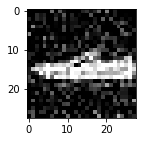

In [82]:
plt.figure(figsize=(2,2))
plt.imshow(X_train_noise[i], cmap="gray")
plt.show()

Como vemos, en comparación a la imagen inicial, esta se ve algo más "borrosa", como era de esperarse. Procedemos entonces a construir el autoencoder con este dataset con un preentrenamiento adicional.

Este autoencoder tiene la misma estructura del anterior:

In [83]:
denoising_autoencoder = Sequential(name="Denoising_Autoencoder")

#Encoder
denoising_autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
denoising_autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
denoising_autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same", name="encoder"))

#Decoder
denoising_autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
denoising_autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

Usamos la misma función de pérdida y optimizador que en el paso 1.2 para el autoencoder:

In [84]:
denoising_autoencoder.compile(loss='mean_squared_error', optimizer='adam')
denoising_autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
encoder (Conv2D)             (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


Finalmente, entrenamos, teniendo en cuenta los callbacks del inicio:

In [85]:
history_denoising = denoising_autoencoder.fit(X_train_noise.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=20, 
                batch_size=200, 
                callbacks=[callbacks],
                validation_data=(
                    X_val_noise.reshape(-1, 28, 28, 1), 
                    X_val.reshape(-1, 28, 28, 1)
                    )
                )

Epoch 1/20
240/240 [==============================] - 5s 22ms/step - loss: 0.0533 - val_loss: 0.0216
Epoch 2/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0187 - val_loss: 0.0165
Epoch 3/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 4/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 5/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 6/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 7/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
240/240 [==============================] - 5s 19ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 10/20
240/240 [==============================] - 5s 20ms/step - loss: 0.0111 - val_lo

Con esto, podemos revisar qué tan bien reconstruidas fueron las imágenes por el autoencoder con ruido. Tomamos sólo las 10 primeras imágenes, como hicimos en el laboratorio:

In [86]:
predichas_denoising = denoising_autoencoder.predict(X_val_noise[:10].reshape(-1, 28, 28, 1))

In [87]:
evaluation_denoising = denoising_autoencoder.evaluate(X_val_noise.reshape(-1, 28, 28, 1), X_val.reshape(-1, 28, 28, 1))
print('Validation Loss : {:.3f}'.format(evaluation_denoising))

375/375 [==============================] - 1s 2ms/step - loss: 0.0102
Validation Loss : 0.010


Revisemos ahora que las imágenes hayan quedado bien reconstruidas. La primera fila representa las imágenes originales. La segunda, corresponde a las imágenes con el ruido impuesto. La última fila corresponde a las imágenes predichas por el denoising autoencoder.

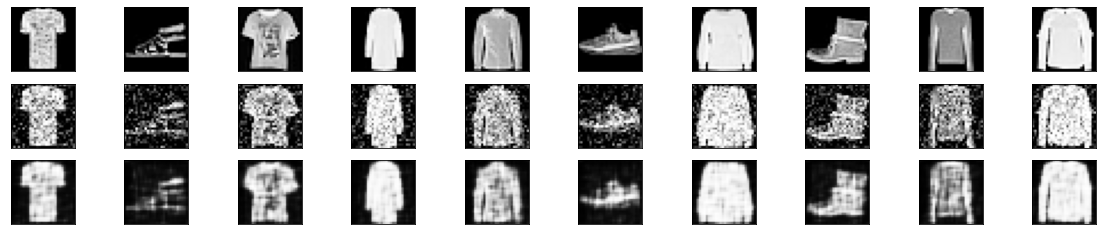

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_val[:10], X_val_noise[:10], predichas_denoising], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Podemos ver que, para el ruido agregado, el modelo reconstruye bastante bien las imágenes (claro está, con un poco menos de fidelidad) pero la "silueta" de la figura se conserva. Incluso con el ruido, un humano puede reconocer la prenda de vestir en cuestión. Note que con este denoising autoencoder, lo que estamos evitando es que el output de la red sea exactamente el input (i.e. que el autoencoder sea la identidad y no esté haciendo nada). 

Aunque es posible que la red de alguna manera esté funcionando como una serie de filtros no lineales, es posible que la aplicación cuidadosa de algunos filtros a manera de preprocesamiento puedan reproducir la imagen de forma más fidedigna, pero contradiciendo el propósito del uso de la representación latente de esta red para la clasificación con un posterior MLP.

Así, podemos construir un MLP (baseline, primero) a partir de la tercera capa (la capa latente) del denoising autoencoder, con _casi_ los mismos parámetros del que hicimos tras el primer autoencoder, en la sección anterior. Lo único diferente será que, para la primera capa densa, bajamos el número de neuronas a 128 y agregaremos una capa profunda adicional (de 64 neuronas), pues se nos está pidiendo específicamente una red profunda. Agregamos consecuentemente una capa de dropout de 0.5, para la regularización. Esta se vuelve especialmente importante porque reduciremos la cantidad de datos. Por esta misma razón, redujimos el número de neuronas. Entonces,

In [152]:
mlp_denoising_autoencoder = Sequential(name='MLP_post_denoising_autoencoder')
# Agregamos hasta la tercera capa del denoising autoencoder a nuestro MLP
mlp_denoising_autoencoder.add(denoising_autoencoder.layers[0])
mlp_denoising_autoencoder.add(denoising_autoencoder.layers[1])
mlp_denoising_autoencoder.add(denoising_autoencoder.layers[2])
# Agregamos una capa para aplanar la imagen y dársela al MLP.
mlp_denoising_autoencoder.add(Flatten())
# Agregamos una capa densa de 128 neuronas con función de activación relu
mlp_denoising_autoencoder.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# Agregamos una capa de regularización con p=0.5 (i.e. máxima regularización)
mlp_denoising_autoencoder.add(Dropout(0.5))
# Agregamos una capa densa de 64 neuronas con función de activación relu
mlp_denoising_autoencoder.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# Agregamos una capa de regularización con p=0.5 (i.e. máxima regularización)
mlp_denoising_autoencoder.add(Dropout(0.5))
# Agregamos la capa de salida
mlp_denoising_autoencoder.add(Dense(10, activation='softmax'))

In [153]:
mlp_denoising_autoencoder.summary()

Model: "MLP_post_denoising_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
encoder (Conv2D)             (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_13 (Flatten)         (None, 392)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               50304     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 

Usamos la misma función de pérdida, optimizador y métrica que para los otros MLP:

In [154]:
mlp_denoising_autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Finalmente, como sugiere el enunciado, recortamos los datos con los que alimentamos el perceptrón al 10%. Por simplicidad, tomamos el 10% inicial de los datos. Así, como

In [155]:
print("Tamaño conjunto entrenamiento:", len(X_train))
print("Tamaño conjunto validación:", len(X_val))

Tamaño conjunto entrenamiento: 48000
Tamaño conjunto validación: 12000


debemos tomar 4800 datos en entrenamiento y 1200 en test. De esta forma,

In [156]:
X_train_noise_reduced, y_train_reduced = X_train_noise[:4800], y_train[:4800]
X_val_noise_reduced, y_val_reduced = X_val_noise[:1200], y_val[:1200]

Usando los callbacks de siempre, obtenemos que:

In [157]:
history_mlp_denoising_autoencoder = mlp_denoising_autoencoder.fit(
                    X_train_noise_reduced.reshape(-1, 28, 28, 1), 
                    y_train_reduced, epochs=50, batch_size=200, callbacks=callbacks,
                    validation_data=(
                    X_val_noise_reduced.reshape(-1, 28, 28, 1), 
                    y_val_reduced
                    ))

Epoch 1/50
24/24 [==============================] - 1s 26ms/step - loss: 3.1067 - accuracy: 0.2271 - val_loss: 1.3777 - val_accuracy: 0.6100
Epoch 2/50
24/24 [==============================] - 0s 18ms/step - loss: 1.6365 - accuracy: 0.4296 - val_loss: 1.0395 - val_accuracy: 0.6925
Epoch 3/50
24/24 [==============================] - 0s 17ms/step - loss: 1.3863 - accuracy: 0.5219 - val_loss: 0.8793 - val_accuracy: 0.7167
Epoch 4/50
24/24 [==============================] - 0s 17ms/step - loss: 1.2199 - accuracy: 0.5798 - val_loss: 0.7827 - val_accuracy: 0.7450
Epoch 5/50
24/24 [==============================] - 0s 17ms/step - loss: 1.0917 - accuracy: 0.6265 - val_loss: 0.7256 - val_accuracy: 0.7542
Epoch 6/50
24/24 [==============================] - 0s 18ms/step - loss: 0.9984 - accuracy: 0.6502 - val_loss: 0.6785 - val_accuracy: 0.7658
Epoch 7/50
24/24 [==============================] - 0s 18ms/step - loss: 0.9262 - accuracy: 0.6785 - val_loss: 0.6555 - val_accuracy: 0.7717
Epoch 8/50
24

In [163]:
# %tensorboard --logdir logs/fit

<img src='fourth_si_si.png'/>

Este reporte sugiere que el modelo puede encontrarse en unz zona de "sub-ajuste" (underfitting): las funciones de pérdida todavía podrían bajas bastante, y las curvas de accuracy parecen estar lejos de estar en overfiitting. Por lo mismo se extendió el número de ciclos de entrenamiento (epoch) y se observaron los resultados. Con ese mayor entrenamiento ya nos estamos acercando al terreno del overfitting, pero no es muy claro, apenas empiezan a empeorar los resultados sobre el conjunto de validación. Es un riesgo natural al tener un conjunto más reducido para el entrenamiento. Es posible que aumentar un poco la regularización pueda ayudar a disminuir ese problema, pero un ajuste fino de la complejidad del modelo es mucho más difícil de solventar.


Ahora, hacemos la búsqueda de hiperparámetros. Por los motivos ya expuestos únicamente ajustamos el número de neuronas, el número de capas y la tasa de Dropout al final de la capa densa.

In [97]:
def entrenar_red(nn1=256, nn2=256, n_layers= 3, dropout_dense=0.5):
    output = 10 # Tenemos 10 neuronas pues son las 10 clases de salida
    clf = Sequential(name='MLP_denoising_autoencoder_CV')
    # Agregamos las 3 primeras capas del autoencoder
    clf.add(denoising_autoencoder.layers[0])
    clf.add(denoising_autoencoder.layers[1])
    clf.add(denoising_autoencoder.layers[2])
    # Agregamos una capa para aplanar la imagen y dársela al MLP.
    clf.add(Flatten())
    first = True

    for i in range(n_layers):
        if i == 0:
            clf.add(Dense(nn1, activation='relu', name='Capa_Oculta_{0}'.format(i))) # num neuronas capa 1
            first = False
        else:
            clf.add(Dense(nn2, activation='relu', name = 'Capa_Oculta_{0}'.format(i))) # num neuronas capa 2, 3 y 4
    # Unicamente antes de que el modelo termine agregamos el dropout.
    clf.add(Dropout(dropout_dense,name='Dropout_dense_{0}'.format(dropout_dense))) # Dropout (parecido a regularizacion)
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida')) # Capa de salidad

    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Valores por defecto
    
    return clf

# Modelo que utiliza el GridSearch
modelCV_mlp_autoencoder_denoising = KerasClassifier(build_fn=entrenar_red, epochs=20, batch_size=500,verbose=1) # Modelo esqueleto

Este modelo "de esqueleto" de hiperparámetros es prácticamente equivalente a la anterior, lo único que cambia son las capas iniciales (le pasamos las del denoising autoencoder).

Para esta búsqueda de hiperparámetros, consideramos un menor número de capas y de neuronas. Sospechamos que el modelo baseline está haciendo overfitting, por las diferencias en las métricas entre entrenamiento y validación. Entonces, disminuimos el número de neuronas y de capas a evaluar.

Consideramos 16, 32 y 64 neuronas entre únicamente 2, 3 o 4 capas (no consideramos una sola pues, según entendemos del enunciado, se quiere una red más profunda - más de una capa).

Como tenemos tan pocos datos aquí, podemos considerar GridSearch y hacer una búsqueda exhaustiva (no Randomized) ya que corre muy rápido.

In [98]:
pipe_3 = Pipeline([('best_MLP_denoising_autoencoder', modelCV_mlp_autoencoder_denoising)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  best_MLP_denoising_autoencoder__nn1 = [16,32,64],
                  best_MLP_denoising_autoencoder__nn2 = [16,32,64],
                  best_MLP_denoising_autoencoder__n_layers = [2,3,4],
                  best_MLP_denoising_autoencoder__dropout_dense = [0.1,0.25,0.5]
                  )

# Definimos la metrica 
score = make_scorer(my_custom_loss_func, greater_is_better=True)

# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
# grid_3 = RandomizedSearchCV(pipe_3, param_grid, verbose=3, cv=3, n_iter=20, random_state=28)
grid_3 = GridSearchCV(pipe_3, param_grid=param_grid,scoring=score,cv=3,verbose=3)

In [99]:
X_joined_train_reduced = np.array(list(X_train_noise_reduced) + list(X_val_noise_reduced))
y_joined_train_reduced = np.array(list(y_train_reduced) + list(y_val_reduced))

In [75]:
grid_3.fit(X_joined_train_reduced.reshape(-1, 28, 28, 1), y_joined_train_reduced, best_MLP_denoising_autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 2.3579 - accuracy: 0.1562
Epoch 2/20
8/8 [==============================] - 0s 21ms/step - loss: 2.0555 - accuracy: 0.3100
Epoch 3/20
8/8 [==============================] - 0s 22ms/step - loss: 1.8919 - accuracy: 0.3900
Epoch 4/20
8/8 [==============================] - 0s 21ms/step - loss: 1.7414 - accuracy: 0.4380
Epoch 5/20
8/8 [==============================] - 0s 22ms/step - loss: 1.6102 - accuracy: 0.4805
Epoch 6/20
8/8 [==============================] - 0s 22ms/step - loss: 1.4557 - accuracy: 0.5397
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 1.3565 - accuracy: 0.5617
Epoch 8/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2522 - accuracy: 0.5870
Epoch 9/20
8/8 [==============================] - 0s 21ms/step - loss: 1.1760 - accuracy: 0.6075
Epoch 10/20
8/8 [==============================] - 0s 22ms/step -

8/8 [==============================] - 0s 22ms/step - loss: 0.7138 - accuracy: 0.7465
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 0.6808 - accuracy: 0.7560
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 0.6633 - accuracy: 0.7645
Epoch 15/20
8/8 [==============================] - 0s 22ms/step - loss: 0.6446 - accuracy: 0.7715
Epoch 16/20
8/8 [==============================] - 0s 21ms/step - loss: 0.6217 - accuracy: 0.7830
Epoch 17/20
8/8 [==============================] - 0s 22ms/step - loss: 0.6154 - accuracy: 0.7835
Epoch 18/20
8/8 [==============================] - 0s 22ms/step - loss: 0.5893 - accuracy: 0.7818
Epoch 19/20
8/8 [==============================] - 0s 21ms/step - loss: 0.5803 - accuracy: 0.7890
Epoch 20/20
8/8 [==============================] - 0s 22ms/step - loss: 0.5737 - accuracy: 0.7937
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.1, best_MLP_denoising_autoencoder__n_layers=2, best_MLP_denoising_aut

8/8 [==============================] - 0s 25ms/step - loss: 1.1518 - accuracy: 0.5903
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0948 - accuracy: 0.6018
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0102 - accuracy: 0.6313
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9506 - accuracy: 0.6553
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9098 - accuracy: 0.6680
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8618 - accuracy: 0.6950
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8407 - accuracy: 0.6892
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7997 - accuracy: 0.7057
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7872 - accuracy: 0.7128
Epoch 16/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7547 - accuracy: 0.7287
Epoch 17/20
8/8 [=================

8/8 [==============================] - 0s 27ms/step - loss: 1.4434 - accuracy: 0.5075
Epoch 3/20
8/8 [==============================] - 0s 27ms/step - loss: 1.1068 - accuracy: 0.6160
Epoch 4/20
8/8 [==============================] - 0s 27ms/step - loss: 0.9291 - accuracy: 0.6575
Epoch 5/20
8/8 [==============================] - 0s 27ms/step - loss: 0.8156 - accuracy: 0.7085
Epoch 6/20
8/8 [==============================] - 0s 27ms/step - loss: 0.7564 - accuracy: 0.7310
Epoch 7/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6994 - accuracy: 0.7505
Epoch 8/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6708 - accuracy: 0.7598
Epoch 9/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6424 - accuracy: 0.7730
Epoch 10/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6167 - accuracy: 0.7760
Epoch 11/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6027 - accuracy: 0.7840
Epoch 12/20
8/8 [======================

8/8 [==============================] - 0s 24ms/step - loss: 0.5162 - accuracy: 0.8245
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5013 - accuracy: 0.8190
Epoch 16/20
8/8 [==============================] - 0s 22ms/step - loss: 0.4921 - accuracy: 0.8235
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4658 - accuracy: 0.8347
Epoch 18/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4724 - accuracy: 0.8275
Epoch 19/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4525 - accuracy: 0.8418
Epoch 20/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4370 - accuracy: 0.8490
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.1, best_MLP_denoising_autoencoder__n_layers=2, best_MLP_denoising_autoencoder__nn1=64, best_MLP_denoising_autoencoder__nn2=32;, score=0.825 total time=   4.6s
Epoch 1/20
8/8 [==============================] - 1s 30ms/step - loss: 2.3902 - accuracy: 0.3015
Epoch 2/2

8/8 [==============================] - 0s 24ms/step - loss: 0.5296 - accuracy: 0.8048
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5047 - accuracy: 0.8140
Epoch 11/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4932 - accuracy: 0.8170
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4676 - accuracy: 0.8282
Epoch 13/20
8/8 [==============================] - 0s 25ms/step - loss: 0.4480 - accuracy: 0.8365
Epoch 14/20
8/8 [==============================] - 0s 25ms/step - loss: 0.4331 - accuracy: 0.8438
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4297 - accuracy: 0.8413
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4099 - accuracy: 0.8518
Epoch 17/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4007 - accuracy: 0.8487
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.3964 - accuracy: 0.8572
Epoch 19/20
8/8 [===============

8/8 [==============================] - 0s 22ms/step - loss: 1.6986 - accuracy: 0.3795
Epoch 5/20
8/8 [==============================] - 0s 22ms/step - loss: 1.4491 - accuracy: 0.5052
Epoch 6/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2185 - accuracy: 0.5972
Epoch 7/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0457 - accuracy: 0.6442
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9356 - accuracy: 0.6685
Epoch 9/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8652 - accuracy: 0.7007
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8206 - accuracy: 0.7025
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 0.7618 - accuracy: 0.7243
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7359 - accuracy: 0.7380
Epoch 13/20
8/8 [==============================] - 0s 21ms/step - loss: 0.7143 - accuracy: 0.7412
Epoch 14/20
8/8 [====================

Epoch 1/20
8/8 [==============================] - 1s 28ms/step - loss: 3.1530 - accuracy: 0.1875
Epoch 2/20
8/8 [==============================] - 0s 25ms/step - loss: 1.9374 - accuracy: 0.3710
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 1.5982 - accuracy: 0.4798
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2748 - accuracy: 0.5602
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0665 - accuracy: 0.6120
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9729 - accuracy: 0.6302
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9045 - accuracy: 0.6495
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8543 - accuracy: 0.6697
Epoch 9/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8093 - accuracy: 0.6923
Epoch 10/20
8/8 [==============================] - 0s 22ms/step - loss: 0.7800 - accuracy: 0.7040
Epoch 11/20
8/8 [============

8/8 [==============================] - 0s 24ms/step - loss: 0.6087 - accuracy: 0.7820
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5848 - accuracy: 0.7897
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5669 - accuracy: 0.8008
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5575 - accuracy: 0.8005
Epoch 17/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5482 - accuracy: 0.8015
Epoch 18/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5318 - accuracy: 0.8105
Epoch 19/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5091 - accuracy: 0.8123
Epoch 20/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5134 - accuracy: 0.8142
[CV 3/3] END best_MLP_denoising_autoencoder__dropout_dense=0.1, best_MLP_denoising_autoencoder__n_layers=3, best_MLP_denoising_autoencoder__nn1=32, best_MLP_denoising_autoencoder__nn2=32;, score=0.789 total time=   4.4s
Epoch 1/

8/8 [==============================] - 0s 24ms/step - loss: 1.3250 - accuracy: 0.5555
Epoch 9/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2823 - accuracy: 0.5750
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.2501 - accuracy: 0.5773
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2262 - accuracy: 0.5955
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1899 - accuracy: 0.6037
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1637 - accuracy: 0.6227
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1529 - accuracy: 0.6292
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1165 - accuracy: 0.6435
Epoch 16/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0846 - accuracy: 0.6580
Epoch 17/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0706 - accuracy: 0.6618
Epoch 18/20
8/8 [================

8/8 [==============================] - 0s 23ms/step - loss: 1.3326 - accuracy: 0.5635
Epoch 4/20
8/8 [==============================] - 0s 24ms/step - loss: 1.1440 - accuracy: 0.6185
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0242 - accuracy: 0.6532
Epoch 6/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8933 - accuracy: 0.6888
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7969 - accuracy: 0.7153
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7158 - accuracy: 0.7475
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6697 - accuracy: 0.7558
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6341 - accuracy: 0.7700
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6035 - accuracy: 0.7840
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5614 - accuracy: 0.7962
Epoch 13/20
8/8 [=====================

8/8 [==============================] - 0s 22ms/step - loss: 1.0417 - accuracy: 0.6215
Epoch 16/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0073 - accuracy: 0.6350
Epoch 17/20
8/8 [==============================] - 0s 21ms/step - loss: 0.9540 - accuracy: 0.6478
Epoch 18/20
8/8 [==============================] - 0s 26ms/step - loss: 0.9387 - accuracy: 0.6532
Epoch 19/20
8/8 [==============================] - 0s 21ms/step - loss: 0.9270 - accuracy: 0.6522
Epoch 20/20
8/8 [==============================] - 0s 19ms/step - loss: 0.8802 - accuracy: 0.6630
[CV 3/3] END best_MLP_denoising_autoencoder__dropout_dense=0.1, best_MLP_denoising_autoencoder__n_layers=4, best_MLP_denoising_autoencoder__nn1=16, best_MLP_denoising_autoencoder__nn2=16;, score=0.665 total time=   4.1s
Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 2.9006 - accuracy: 0.1570
Epoch 2/20
8/8 [==============================] - 0s 23ms/step - loss: 1.9060 - accuracy: 0.3105
Epoch 3/20

8/8 [==============================] - 0s 22ms/step - loss: 0.6246 - accuracy: 0.7602
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 0.5927 - accuracy: 0.7797
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5837 - accuracy: 0.7830
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5725 - accuracy: 0.7850
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5555 - accuracy: 0.7912
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5382 - accuracy: 0.8000
Epoch 16/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5295 - accuracy: 0.8058
Epoch 17/20
8/8 [==============================] - 0s 22ms/step - loss: 0.5286 - accuracy: 0.8062
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5198 - accuracy: 0.8085
Epoch 19/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4995 - accuracy: 0.8215
Epoch 20/20
8/8 [===============

8/8 [==============================] - 0s 24ms/step - loss: 1.5102 - accuracy: 0.4720
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3755 - accuracy: 0.5403
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 1.2829 - accuracy: 0.5748
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1473 - accuracy: 0.6200
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0726 - accuracy: 0.6465
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9988 - accuracy: 0.6665
Epoch 11/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9507 - accuracy: 0.6810
Epoch 12/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9207 - accuracy: 0.6895
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8770 - accuracy: 0.7028
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8290 - accuracy: 0.7240
Epoch 15/20
8/8 [===================

Epoch 1/20
8/8 [==============================] - 1s 32ms/step - loss: 2.9429 - accuracy: 0.1893
Epoch 2/20
8/8 [==============================] - 0s 28ms/step - loss: 1.7868 - accuracy: 0.3350
Epoch 3/20
8/8 [==============================] - 0s 25ms/step - loss: 1.4547 - accuracy: 0.4725
Epoch 4/20
8/8 [==============================] - 0s 25ms/step - loss: 1.2101 - accuracy: 0.5850
Epoch 5/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0525 - accuracy: 0.6323
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9239 - accuracy: 0.6773
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8337 - accuracy: 0.7023
Epoch 8/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7803 - accuracy: 0.7210
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7201 - accuracy: 0.7458
Epoch 10/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6883 - accuracy: 0.7505
Epoch 11/20
8/8 [============

8/8 [==============================] - 0s 24ms/step - loss: 0.5590 - accuracy: 0.7912
Epoch 14/20
8/8 [==============================] - 0s 26ms/step - loss: 0.5435 - accuracy: 0.8012
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5213 - accuracy: 0.8092
Epoch 16/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5112 - accuracy: 0.8175
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4769 - accuracy: 0.8257
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4632 - accuracy: 0.8310
Epoch 19/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4560 - accuracy: 0.8347
Epoch 20/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4439 - accuracy: 0.8345
[CV 1/3] END best_MLP_denoising_autoencoder__dropout_dense=0.1, best_MLP_denoising_autoencoder__n_layers=4, best_MLP_denoising_autoencoder__nn1=64, best_MLP_denoising_autoencoder__nn2=32;, score=0.815 total time=   4.5s
Epoch 1/

8/8 [==============================] - 0s 25ms/step - loss: 0.5858 - accuracy: 0.7905
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5511 - accuracy: 0.8005
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5115 - accuracy: 0.8127
Epoch 11/20
8/8 [==============================] - 0s 25ms/step - loss: 0.4972 - accuracy: 0.8255
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 0.4785 - accuracy: 0.8285
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4581 - accuracy: 0.8360
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4296 - accuracy: 0.8462
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.4184 - accuracy: 0.8480
Epoch 16/20
8/8 [==============================] - 0s 26ms/step - loss: 0.4086 - accuracy: 0.8497
Epoch 17/20
8/8 [==============================] - 0s 25ms/step - loss: 0.3959 - accuracy: 0.8533
Epoch 18/20
8/8 [================

8/8 [==============================] - 0s 20ms/step - loss: 2.0006 - accuracy: 0.2348
Epoch 4/20
8/8 [==============================] - 0s 20ms/step - loss: 1.8820 - accuracy: 0.2867
Epoch 5/20
8/8 [==============================] - 0s 22ms/step - loss: 1.7845 - accuracy: 0.3255
Epoch 6/20
8/8 [==============================] - 0s 21ms/step - loss: 1.6688 - accuracy: 0.3638
Epoch 7/20
8/8 [==============================] - 0s 21ms/step - loss: 1.5724 - accuracy: 0.4072
Epoch 8/20
8/8 [==============================] - 0s 20ms/step - loss: 1.4804 - accuracy: 0.4618
Epoch 9/20
8/8 [==============================] - 0s 20ms/step - loss: 1.4034 - accuracy: 0.4870
Epoch 10/20
8/8 [==============================] - 0s 21ms/step - loss: 1.3271 - accuracy: 0.5185
Epoch 11/20
8/8 [==============================] - 0s 21ms/step - loss: 1.2496 - accuracy: 0.5558
Epoch 12/20
8/8 [==============================] - 0s 21ms/step - loss: 1.2039 - accuracy: 0.5795
Epoch 13/20
8/8 [=====================

8/8 [==============================] - 0s 24ms/step - loss: 0.8694 - accuracy: 0.6985
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8577 - accuracy: 0.7107
Epoch 17/20
8/8 [==============================] - 0s 27ms/step - loss: 0.8416 - accuracy: 0.7113
Epoch 18/20
8/8 [==============================] - 0s 28ms/step - loss: 0.8275 - accuracy: 0.7063
Epoch 19/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7940 - accuracy: 0.7322
Epoch 20/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7897 - accuracy: 0.7275
[CV 1/3] END best_MLP_denoising_autoencoder__dropout_dense=0.25, best_MLP_denoising_autoencoder__n_layers=2, best_MLP_denoising_autoencoder__nn1=32, best_MLP_denoising_autoencoder__nn2=16;, score=0.785 total time=   4.4s
Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 2.5363 - accuracy: 0.1797
Epoch 2/20
8/8 [==============================] - 0s 23ms/step - loss: 1.7643 - accuracy: 0.3923
Epoch 3/2

8/8 [==============================] - 0s 23ms/step - loss: 0.9737 - accuracy: 0.6605
Epoch 11/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9350 - accuracy: 0.6715
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8867 - accuracy: 0.6973
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8395 - accuracy: 0.7147
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8128 - accuracy: 0.7200
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7827 - accuracy: 0.7337
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7582 - accuracy: 0.7398
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7521 - accuracy: 0.7418
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7111 - accuracy: 0.7525
Epoch 19/20
8/8 [==============================] - 0s 25ms/step - loss: 0.6890 - accuracy: 0.7563
Epoch 20/20
8/8 [===============

8/8 [==============================] - 0s 26ms/step - loss: 0.9343 - accuracy: 0.6618
Epoch 6/20
8/8 [==============================] - 0s 26ms/step - loss: 0.8364 - accuracy: 0.6930
Epoch 7/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7868 - accuracy: 0.7212
Epoch 8/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7465 - accuracy: 0.7405
Epoch 9/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6899 - accuracy: 0.7505
Epoch 10/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6676 - accuracy: 0.7598
Epoch 11/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6490 - accuracy: 0.7720
Epoch 12/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6252 - accuracy: 0.7795
Epoch 13/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6130 - accuracy: 0.7760
Epoch 14/20
8/8 [==============================] - 0s 27ms/step - loss: 0.5852 - accuracy: 0.7925
Epoch 15/20
8/8 [===================

Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 4.0748 - accuracy: 0.1867
Epoch 2/20
8/8 [==============================] - 0s 25ms/step - loss: 1.6899 - accuracy: 0.3925
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3921 - accuracy: 0.4920
Epoch 4/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1885 - accuracy: 0.5745
Epoch 5/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0646 - accuracy: 0.6285
Epoch 6/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9663 - accuracy: 0.6540
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9141 - accuracy: 0.6760
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8504 - accuracy: 0.6963
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8185 - accuracy: 0.7155
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7653 - accuracy: 0.7210
Epoch 11/20
8/8 [============

Epoch 13/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0795 - accuracy: 0.6220
Epoch 14/20
8/8 [==============================] - 0s 21ms/step - loss: 1.0184 - accuracy: 0.6410
Epoch 15/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0000 - accuracy: 0.6470
Epoch 16/20
8/8 [==============================] - 0s 20ms/step - loss: 0.9605 - accuracy: 0.6635
Epoch 17/20
8/8 [==============================] - 0s 22ms/step - loss: 0.9344 - accuracy: 0.6647
Epoch 18/20
8/8 [==============================] - 0s 22ms/step - loss: 0.9192 - accuracy: 0.6823
Epoch 19/20
8/8 [==============================] - 0s 20ms/step - loss: 0.8886 - accuracy: 0.6927
Epoch 20/20
8/8 [==============================] - 0s 22ms/step - loss: 0.8953 - accuracy: 0.6873
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.25, best_MLP_denoising_autoencoder__n_layers=3, best_MLP_denoising_autoencoder__nn1=16, best_MLP_denoising_autoencoder__nn2=16;, score=0.762 total time=   

8/8 [==============================] - 0s 25ms/step - loss: 2.0177 - accuracy: 0.2915
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 1.8661 - accuracy: 0.3532
Epoch 4/20
8/8 [==============================] - 0s 25ms/step - loss: 1.7596 - accuracy: 0.3815
Epoch 5/20
8/8 [==============================] - 0s 27ms/step - loss: 1.6359 - accuracy: 0.4263
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 1.4823 - accuracy: 0.4868
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 1.4163 - accuracy: 0.5080
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3164 - accuracy: 0.5580
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 1.2588 - accuracy: 0.5698
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.1996 - accuracy: 0.5857
Epoch 11/20
8/8 [==============================] - 0s 25ms/step - loss: 1.1469 - accuracy: 0.6058
Epoch 12/20
8/8 [======================

8/8 [==============================] - 0s 28ms/step - loss: 0.5800 - accuracy: 0.7955
Epoch 15/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5770 - accuracy: 0.7958
Epoch 16/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5405 - accuracy: 0.8070
Epoch 17/20
8/8 [==============================] - 0s 27ms/step - loss: 0.5291 - accuracy: 0.8102
Epoch 18/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5192 - accuracy: 0.8150
Epoch 19/20
8/8 [==============================] - 0s 27ms/step - loss: 0.4975 - accuracy: 0.8202
Epoch 20/20
8/8 [==============================] - 0s 27ms/step - loss: 0.4965 - accuracy: 0.8235
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.25, best_MLP_denoising_autoencoder__n_layers=3, best_MLP_denoising_autoencoder__nn1=32, best_MLP_denoising_autoencoder__nn2=64;, score=0.807 total time=   4.9s
Epoch 1/20
8/8 [==============================] - 1s 33ms/step - loss: 2.7706 - accuracy: 0.1845
Epoch 2/

8/8 [==============================] - 0s 23ms/step - loss: 1.2199 - accuracy: 0.5555
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1954 - accuracy: 0.5600
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 1.1698 - accuracy: 0.5627
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1172 - accuracy: 0.5835
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1058 - accuracy: 0.5882
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0671 - accuracy: 0.6012
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 1.0375 - accuracy: 0.6200
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0206 - accuracy: 0.6255
Epoch 17/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0040 - accuracy: 0.6440
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9908 - accuracy: 0.6515
Epoch 19/20
8/8 [===============

8/8 [==============================] - 0s 24ms/step - loss: 0.8613 - accuracy: 0.7050
Epoch 5/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7600 - accuracy: 0.7372
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6916 - accuracy: 0.7590
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6413 - accuracy: 0.7692
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6041 - accuracy: 0.7847
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5641 - accuracy: 0.7947
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5445 - accuracy: 0.8035
Epoch 11/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5183 - accuracy: 0.8127
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5094 - accuracy: 0.8175
Epoch 13/20
8/8 [==============================] - 0s 25ms/step - loss: 0.4779 - accuracy: 0.8278
Epoch 14/20
8/8 [====================

Epoch 1/20
8/8 [==============================] - 1s 28ms/step - loss: 2.4426 - accuracy: 0.1007
Epoch 2/20
8/8 [==============================] - 0s 24ms/step - loss: 2.0511 - accuracy: 0.2403
Epoch 3/20
8/8 [==============================] - 0s 22ms/step - loss: 1.7927 - accuracy: 0.3338
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 1.6299 - accuracy: 0.4040
Epoch 5/20
8/8 [==============================] - 0s 21ms/step - loss: 1.4941 - accuracy: 0.4460
Epoch 6/20
8/8 [==============================] - 0s 21ms/step - loss: 1.3865 - accuracy: 0.5102
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 1.3137 - accuracy: 0.5360
Epoch 8/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2669 - accuracy: 0.5605
Epoch 9/20
8/8 [==============================] - 0s 22ms/step - loss: 1.2020 - accuracy: 0.5700
Epoch 10/20
8/8 [==============================] - 0s 22ms/step - loss: 1.1128 - accuracy: 0.6105
Epoch 11/20
8/8 [============

8/8 [==============================] - 0s 24ms/step - loss: 0.6154 - accuracy: 0.7660
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5941 - accuracy: 0.7735
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5758 - accuracy: 0.7760
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5630 - accuracy: 0.7855
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5628 - accuracy: 0.7837
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5378 - accuracy: 0.7928
Epoch 19/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5325 - accuracy: 0.7952
Epoch 20/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5194 - accuracy: 0.8008
[CV 3/3] END best_MLP_denoising_autoencoder__dropout_dense=0.25, best_MLP_denoising_autoencoder__n_layers=4, best_MLP_denoising_autoencoder__nn1=16, best_MLP_denoising_autoencoder__nn2=64;, score=0.792 total time=   4.4s
Epoch 1

8/8 [==============================] - 0s 24ms/step - loss: 1.1780 - accuracy: 0.5788
Epoch 9/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0745 - accuracy: 0.6338
Epoch 10/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0094 - accuracy: 0.6605
Epoch 11/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9362 - accuracy: 0.6873
Epoch 12/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8802 - accuracy: 0.6935
Epoch 13/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8431 - accuracy: 0.7113
Epoch 14/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7870 - accuracy: 0.7295
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7684 - accuracy: 0.7387
Epoch 16/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7561 - accuracy: 0.7347
Epoch 17/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7179 - accuracy: 0.7517
Epoch 18/20
8/8 [================

8/8 [==============================] - 0s 28ms/step - loss: 1.3376 - accuracy: 0.5390
Epoch 4/20
8/8 [==============================] - 0s 27ms/step - loss: 1.0801 - accuracy: 0.6220
Epoch 5/20
8/8 [==============================] - 0s 26ms/step - loss: 0.9412 - accuracy: 0.6605
Epoch 6/20
8/8 [==============================] - 0s 28ms/step - loss: 0.8413 - accuracy: 0.6938
Epoch 7/20
8/8 [==============================] - 0s 27ms/step - loss: 0.7773 - accuracy: 0.7215
Epoch 8/20
8/8 [==============================] - 0s 28ms/step - loss: 0.7009 - accuracy: 0.7508
Epoch 9/20
8/8 [==============================] - 0s 29ms/step - loss: 0.6737 - accuracy: 0.7605
Epoch 10/20
8/8 [==============================] - 0s 28ms/step - loss: 0.6369 - accuracy: 0.7682
Epoch 11/20
8/8 [==============================] - 0s 28ms/step - loss: 0.6260 - accuracy: 0.7765
Epoch 12/20
8/8 [==============================] - 0s 28ms/step - loss: 0.5981 - accuracy: 0.7843
Epoch 13/20
8/8 [=====================

8/8 [==============================] - 0s 24ms/step - loss: 0.6373 - accuracy: 0.7715
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6144 - accuracy: 0.7895
Epoch 17/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5862 - accuracy: 0.7922
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5896 - accuracy: 0.7987
Epoch 19/20
8/8 [==============================] - 0s 26ms/step - loss: 0.5563 - accuracy: 0.8070
Epoch 20/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5391 - accuracy: 0.8127
[CV 3/3] END best_MLP_denoising_autoencoder__dropout_dense=0.25, best_MLP_denoising_autoencoder__n_layers=4, best_MLP_denoising_autoencoder__nn1=64, best_MLP_denoising_autoencoder__nn2=32;, score=0.802 total time=   4.5s
Epoch 1/20
8/8 [==============================] - 1s 31ms/step - loss: 2.7847 - accuracy: 0.2772
Epoch 2/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3643 - accuracy: 0.5447
Epoch 3/2

8/8 [==============================] - 0s 21ms/step - loss: 2.0289 - accuracy: 0.2693
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 1.9895 - accuracy: 0.2887
Epoch 12/20
8/8 [==============================] - 0s 20ms/step - loss: 1.9766 - accuracy: 0.2870
Epoch 13/20
8/8 [==============================] - 0s 22ms/step - loss: 1.9304 - accuracy: 0.2937
Epoch 14/20
8/8 [==============================] - 0s 21ms/step - loss: 1.9137 - accuracy: 0.2962
Epoch 15/20
8/8 [==============================] - 0s 22ms/step - loss: 1.8933 - accuracy: 0.3142
Epoch 16/20
8/8 [==============================] - 0s 21ms/step - loss: 1.8782 - accuracy: 0.3100
Epoch 17/20
8/8 [==============================] - 0s 21ms/step - loss: 1.8383 - accuracy: 0.3200
Epoch 18/20
8/8 [==============================] - 0s 20ms/step - loss: 1.8203 - accuracy: 0.3442
Epoch 19/20
8/8 [==============================] - 0s 21ms/step - loss: 1.7972 - accuracy: 0.3577
Epoch 20/20
8/8 [===============

8/8 [==============================] - 0s 21ms/step - loss: 2.0731 - accuracy: 0.2445
Epoch 6/20
8/8 [==============================] - 0s 21ms/step - loss: 1.9824 - accuracy: 0.2783
Epoch 7/20
8/8 [==============================] - 0s 22ms/step - loss: 1.8975 - accuracy: 0.3065
Epoch 8/20
8/8 [==============================] - 0s 22ms/step - loss: 1.8121 - accuracy: 0.3417
Epoch 9/20
8/8 [==============================] - 0s 22ms/step - loss: 1.7357 - accuracy: 0.3740
Epoch 10/20
8/8 [==============================] - 0s 22ms/step - loss: 1.6784 - accuracy: 0.3930
Epoch 11/20
8/8 [==============================] - 0s 23ms/step - loss: 1.5776 - accuracy: 0.4300
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 1.5164 - accuracy: 0.4495
Epoch 13/20
8/8 [==============================] - 0s 22ms/step - loss: 1.4023 - accuracy: 0.4860
Epoch 14/20
8/8 [==============================] - 0s 22ms/step - loss: 1.3397 - accuracy: 0.5123
Epoch 15/20
8/8 [===================

Epoch 1/20
8/8 [==============================] - 0s 27ms/step - loss: 2.8132 - accuracy: 0.1480
Epoch 2/20
8/8 [==============================] - 0s 21ms/step - loss: 2.0433 - accuracy: 0.2570
Epoch 3/20
8/8 [==============================] - 0s 23ms/step - loss: 1.8493 - accuracy: 0.3298
Epoch 4/20
8/8 [==============================] - 0s 23ms/step - loss: 1.6974 - accuracy: 0.3755
Epoch 5/20
8/8 [==============================] - 0s 21ms/step - loss: 1.5746 - accuracy: 0.4297
Epoch 6/20
8/8 [==============================] - 0s 21ms/step - loss: 1.4738 - accuracy: 0.4575
Epoch 7/20
8/8 [==============================] - 0s 21ms/step - loss: 1.3345 - accuracy: 0.5132
Epoch 8/20
8/8 [==============================] - 0s 20ms/step - loss: 1.2649 - accuracy: 0.5477
Epoch 9/20
8/8 [==============================] - 0s 22ms/step - loss: 1.1737 - accuracy: 0.5798
Epoch 10/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0944 - accuracy: 0.6053
Epoch 11/20
8/8 [============

8/8 [==============================] - 0s 27ms/step - loss: 0.7546 - accuracy: 0.7303
Epoch 14/20
8/8 [==============================] - 0s 27ms/step - loss: 0.7245 - accuracy: 0.7470
Epoch 15/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6955 - accuracy: 0.7580
Epoch 16/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6812 - accuracy: 0.7570
Epoch 17/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6604 - accuracy: 0.7713
Epoch 18/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6513 - accuracy: 0.7753
Epoch 19/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6151 - accuracy: 0.7843
Epoch 20/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6364 - accuracy: 0.7790
[CV 1/3] END best_MLP_denoising_autoencoder__dropout_dense=0.5, best_MLP_denoising_autoencoder__n_layers=2, best_MLP_denoising_autoencoder__nn1=32, best_MLP_denoising_autoencoder__nn2=64;, score=0.809 total time=   4.8s
Epoch 1/

8/8 [==============================] - 0s 24ms/step - loss: 1.4506 - accuracy: 0.4363
Epoch 9/20
8/8 [==============================] - 0s 21ms/step - loss: 1.4220 - accuracy: 0.4593
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3610 - accuracy: 0.4940
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 1.3297 - accuracy: 0.5023
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2832 - accuracy: 0.5100
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2574 - accuracy: 0.5357
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2536 - accuracy: 0.5372
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2062 - accuracy: 0.5543
Epoch 16/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2038 - accuracy: 0.5577
Epoch 17/20
8/8 [==============================] - 0s 22ms/step - loss: 1.1480 - accuracy: 0.5817
Epoch 18/20
8/8 [================

8/8 [==============================] - 0s 22ms/step - loss: 1.6485 - accuracy: 0.4428
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 1.5034 - accuracy: 0.4975
Epoch 5/20
8/8 [==============================] - 0s 22ms/step - loss: 1.3839 - accuracy: 0.5375
Epoch 6/20
8/8 [==============================] - 0s 25ms/step - loss: 1.2743 - accuracy: 0.5727
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1921 - accuracy: 0.5918
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 1.1008 - accuracy: 0.6215
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0640 - accuracy: 0.6283
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0103 - accuracy: 0.6457
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9597 - accuracy: 0.6565
Epoch 12/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9243 - accuracy: 0.6745
Epoch 13/20
8/8 [=====================

8/8 [==============================] - 0s 23ms/step - loss: 1.1303 - accuracy: 0.5865
Epoch 16/20
8/8 [==============================] - 0s 22ms/step - loss: 1.0647 - accuracy: 0.6087
Epoch 17/20
8/8 [==============================] - 0s 21ms/step - loss: 1.0238 - accuracy: 0.6300
Epoch 18/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9810 - accuracy: 0.6455
Epoch 19/20
8/8 [==============================] - 0s 22ms/step - loss: 0.9520 - accuracy: 0.6562
Epoch 20/20
8/8 [==============================] - 0s 23ms/step - loss: 0.9328 - accuracy: 0.6670
[CV 1/3] END best_MLP_denoising_autoencoder__dropout_dense=0.5, best_MLP_denoising_autoencoder__n_layers=3, best_MLP_denoising_autoencoder__nn1=16, best_MLP_denoising_autoencoder__nn2=32;, score=0.760 total time=   4.2s
Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 3.8126 - accuracy: 0.1425
Epoch 2/20
8/8 [==============================] - 0s 21ms/step - loss: 2.2878 - accuracy: 0.2015
Epoch 3/20

8/8 [==============================] - 0s 25ms/step - loss: 0.9105 - accuracy: 0.6835
Epoch 11/20
8/8 [==============================] - 0s 27ms/step - loss: 0.8673 - accuracy: 0.6955
Epoch 12/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8187 - accuracy: 0.7175
Epoch 13/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7791 - accuracy: 0.7372
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7554 - accuracy: 0.7408
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7449 - accuracy: 0.7458
Epoch 16/20
8/8 [==============================] - 0s 28ms/step - loss: 0.7264 - accuracy: 0.7505
Epoch 17/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7215 - accuracy: 0.7470
Epoch 18/20
8/8 [==============================] - 0s 27ms/step - loss: 0.6844 - accuracy: 0.7685
Epoch 19/20
8/8 [==============================] - 0s 26ms/step - loss: 0.6771 - accuracy: 0.7670
Epoch 20/20
8/8 [===============

8/8 [==============================] - 0s 24ms/step - loss: 1.9138 - accuracy: 0.2792
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 1.8658 - accuracy: 0.3010
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 1.8086 - accuracy: 0.3313
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 1.7659 - accuracy: 0.3442
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 1.7378 - accuracy: 0.3733
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.7051 - accuracy: 0.4045
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 1.6956 - accuracy: 0.4255
Epoch 12/20
8/8 [==============================] - 0s 25ms/step - loss: 1.6497 - accuracy: 0.4327
Epoch 13/20
8/8 [==============================] - 0s 25ms/step - loss: 1.6058 - accuracy: 0.4570
Epoch 14/20
8/8 [==============================] - 0s 24ms/step - loss: 1.5864 - accuracy: 0.4678
Epoch 15/20
8/8 [===================

Epoch 1/20
8/8 [==============================] - 1s 33ms/step - loss: 2.7108 - accuracy: 0.1595
Epoch 2/20
8/8 [==============================] - 0s 27ms/step - loss: 1.9868 - accuracy: 0.2808
Epoch 3/20
8/8 [==============================] - 0s 28ms/step - loss: 1.6800 - accuracy: 0.4083
Epoch 4/20
8/8 [==============================] - 0s 27ms/step - loss: 1.4154 - accuracy: 0.5155
Epoch 5/20
8/8 [==============================] - 0s 26ms/step - loss: 1.2123 - accuracy: 0.5720
Epoch 6/20
8/8 [==============================] - 0s 27ms/step - loss: 1.0575 - accuracy: 0.6400
Epoch 7/20
8/8 [==============================] - 0s 26ms/step - loss: 0.9611 - accuracy: 0.6665
Epoch 8/20
8/8 [==============================] - 0s 27ms/step - loss: 0.8945 - accuracy: 0.6865
Epoch 9/20
8/8 [==============================] - 0s 28ms/step - loss: 0.8356 - accuracy: 0.7182
Epoch 10/20
8/8 [==============================] - 0s 26ms/step - loss: 0.7888 - accuracy: 0.7308
Epoch 11/20
8/8 [============

8/8 [==============================] - 0s 24ms/step - loss: 0.9807 - accuracy: 0.6355
Epoch 13/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9357 - accuracy: 0.6618
Epoch 14/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8914 - accuracy: 0.6775
Epoch 15/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8697 - accuracy: 0.6865
Epoch 16/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8399 - accuracy: 0.6982
Epoch 17/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8171 - accuracy: 0.7038
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7962 - accuracy: 0.7210
Epoch 19/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7747 - accuracy: 0.7218
Epoch 20/20
8/8 [==============================] - 0s 25ms/step - loss: 0.7542 - accuracy: 0.7345
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.5, best_MLP_denoising_autoencoder__n_layers=3, best_MLP_denoising_aut

8/8 [==============================] - 0s 24ms/step - loss: 0.8154 - accuracy: 0.7258
Epoch 8/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7730 - accuracy: 0.7310
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7058 - accuracy: 0.7605
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 0.6742 - accuracy: 0.7615
Epoch 11/20
8/8 [==============================] - 0s 23ms/step - loss: 0.6641 - accuracy: 0.7715
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6330 - accuracy: 0.7788
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6162 - accuracy: 0.7878
Epoch 14/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5690 - accuracy: 0.8070
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.5538 - accuracy: 0.8077
Epoch 16/20
8/8 [==============================] - 0s 24ms/step - loss: 0.5467 - accuracy: 0.8105
Epoch 17/20
8/8 [=================

8/8 [==============================] - 0s 21ms/step - loss: 2.2560 - accuracy: 0.1940
Epoch 3/20
8/8 [==============================] - 0s 22ms/step - loss: 2.1062 - accuracy: 0.2320
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 1.9947 - accuracy: 0.2702
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 1.8603 - accuracy: 0.3153
Epoch 6/20
8/8 [==============================] - 0s 21ms/step - loss: 1.7829 - accuracy: 0.3385
Epoch 7/20
8/8 [==============================] - 0s 20ms/step - loss: 1.7028 - accuracy: 0.3643
Epoch 8/20
8/8 [==============================] - 0s 22ms/step - loss: 1.5994 - accuracy: 0.4038
Epoch 9/20
8/8 [==============================] - 0s 23ms/step - loss: 1.5222 - accuracy: 0.4383
Epoch 10/20
8/8 [==============================] - 0s 23ms/step - loss: 1.4451 - accuracy: 0.4663
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 1.3683 - accuracy: 0.5173
Epoch 12/20
8/8 [======================

8/8 [==============================] - 0s 25ms/step - loss: 1.3519 - accuracy: 0.5000
Epoch 15/20
8/8 [==============================] - 0s 23ms/step - loss: 1.3234 - accuracy: 0.5160
Epoch 16/20
8/8 [==============================] - 0s 25ms/step - loss: 1.2722 - accuracy: 0.5320
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 1.2484 - accuracy: 0.5330
Epoch 18/20
8/8 [==============================] - 0s 26ms/step - loss: 1.2100 - accuracy: 0.5530
Epoch 19/20
8/8 [==============================] - 0s 22ms/step - loss: 1.1830 - accuracy: 0.5560
Epoch 20/20
8/8 [==============================] - 0s 24ms/step - loss: 1.1537 - accuracy: 0.5692
[CV 2/3] END best_MLP_denoising_autoencoder__dropout_dense=0.5, best_MLP_denoising_autoencoder__n_layers=4, best_MLP_denoising_autoencoder__nn1=32, best_MLP_denoising_autoencoder__nn2=16;, score=0.750 total time=   4.5s
Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 2.6915 - accuracy: 0.1295
Epoch 2/2

8/8 [==============================] - 0s 24ms/step - loss: 1.0784 - accuracy: 0.6280
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.0333 - accuracy: 0.6355
Epoch 11/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9650 - accuracy: 0.6575
Epoch 12/20
8/8 [==============================] - 0s 25ms/step - loss: 0.9284 - accuracy: 0.6833
Epoch 13/20
8/8 [==============================] - 0s 24ms/step - loss: 0.9059 - accuracy: 0.6852
Epoch 14/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8769 - accuracy: 0.6905
Epoch 15/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8549 - accuracy: 0.6975
Epoch 16/20
8/8 [==============================] - 0s 25ms/step - loss: 0.8170 - accuracy: 0.7072
Epoch 17/20
8/8 [==============================] - 0s 23ms/step - loss: 0.7934 - accuracy: 0.7200
Epoch 18/20
8/8 [==============================] - 0s 24ms/step - loss: 0.7898 - accuracy: 0.7237
Epoch 19/20
8/8 [===============

8/8 [==============================] - 0s 24ms/step - loss: 1.9044 - accuracy: 0.3010
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 1.8378 - accuracy: 0.3158
Epoch 6/20
8/8 [==============================] - 0s 26ms/step - loss: 1.7656 - accuracy: 0.3325
Epoch 7/20
8/8 [==============================] - 0s 25ms/step - loss: 1.7200 - accuracy: 0.3580
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 1.6381 - accuracy: 0.3828
Epoch 9/20
8/8 [==============================] - 0s 22ms/step - loss: 1.5802 - accuracy: 0.4025
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 1.5585 - accuracy: 0.4078
Epoch 11/20
8/8 [==============================] - 0s 22ms/step - loss: 1.5006 - accuracy: 0.4210
Epoch 12/20
8/8 [==============================] - 0s 24ms/step - loss: 1.4491 - accuracy: 0.4465
Epoch 13/20
8/8 [==============================] - 0s 23ms/step - loss: 1.3873 - accuracy: 0.4608
Epoch 14/20
8/8 [====================

Epoch 1/20
8/8 [==============================] - 1s 32ms/step - loss: 3.2800 - accuracy: 0.1460
Epoch 2/20
8/8 [==============================] - 0s 25ms/step - loss: 2.0386 - accuracy: 0.2528
Epoch 3/20
8/8 [==============================] - 0s 25ms/step - loss: 1.8008 - accuracy: 0.3455
Epoch 4/20
8/8 [==============================] - 0s 24ms/step - loss: 1.6178 - accuracy: 0.4243
Epoch 5/20
8/8 [==============================] - 0s 25ms/step - loss: 1.4686 - accuracy: 0.4900
Epoch 6/20
8/8 [==============================] - 0s 25ms/step - loss: 1.3727 - accuracy: 0.5230
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 1.2440 - accuracy: 0.5627
Epoch 8/20
8/8 [==============================] - 0s 25ms/step - loss: 1.1275 - accuracy: 0.5945
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 1.1149 - accuracy: 0.6053
Epoch 10/20
8/8 [==============================] - 0s 25ms/step - loss: 1.0477 - accuracy: 0.6260
Epoch 11/20
8/8 [============

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('best_MLP_denoising_autoencoder',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc6e19f58e0>)]),
             param_grid={'best_MLP_denoising_autoencoder__dropout_dense': [0.1,
                                                                           0.25,
                                                                           0.5],
                         'best_MLP_denoising_autoencoder__n_layers': [2, 3, 4],
                         'best_MLP_denoising_autoencoder__nn1': [16, 32, 64],
                         'best_MLP_denoising_autoencoder__nn2': [16, 32, 64]},
             scoring=make_scorer(my_custom_loss_func), verbose=3)

In [76]:
best_model_mlp_autoencoder_denoising = grid_3.best_estimator_
best_model_mlp_autoencoder_denoising['best_MLP_denoising_autoencoder'].model.summary()

Model: "MLP_denoising_autoencoder_CV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
encoder (Conv2D)             (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_309 (Flatten)        (None, 392)               0         
_________________________________________________________________
Capa_Oculta_0 (Dense)        (None, 64)                25152     
_________________________________________________________________
Capa_Oculta_1 (Dense)        (None, 64)                4160      
_________________________________________________________________
Dropout_dense_0.25 (Dropout) (None, 64

In [77]:
best_score_mlp_autoencoder_denoising = grid_3.best_score_
print('La accuracy del mejor modelo para MLP post-autoencoder denoising es: ', best_score_mlp_autoencoder_denoising)

La accuracy del mejor modelo para MLP post-autoencoder denoising es:  0.824


In [80]:
grid_3.cv_results_['mean_test_score']

array([0.7495    , 0.76383333, 0.7895    , 0.783     , 0.80316667,
       0.80733333, 0.7995    , 0.8145    , 0.81883333, 0.73183333,
       0.7825    , 0.79      , 0.7845    , 0.79283333, 0.80916667,
       0.76416667, 0.81      , 0.82116667, 0.728     , 0.77366667,
       0.792     , 0.76633333, 0.795     , 0.80583333, 0.79316667,
       0.80983333, 0.816     , 0.74916667, 0.7765    , 0.78266667,
       0.779     , 0.79016667, 0.797     , 0.79516667, 0.80666667,
       0.824     , 0.725     , 0.75633333, 0.79616667, 0.76283333,
       0.8005    , 0.80983333, 0.78116667, 0.80916667, 0.8175    ,
       0.72316667, 0.75683333, 0.79716667, 0.7645    , 0.78783333,
       0.80716667, 0.78483333, 0.80216667, 0.8215    , 0.6345    ,
       0.69716667, 0.767     , 0.74866667, 0.76933333, 0.79666667,
       0.77616667, 0.79833333, 0.81616667, 0.70833333, 0.75233333,
       0.76733333, 0.7065    , 0.78383333, 0.8065    , 0.71033333,
       0.796     , 0.81466667, 0.73916667, 0.76316667, 0.7915 

Como podemos ver arriba, la mayoría de modelos no se comportan tan bien como los explorados anteriormente. En esta búsqueda exhaustiva, los rendimientos de encuentran entre 0.6345 y 0.824, números bastante inferiores a las familias de modelos exploradas anteriormente.

Podemos ver que en los tres modelos que planteamos, a los que les ajustamos los hiperparámetros con Cross Validation eran los que mejores resultados tenían para la exactitud. Por lo tanto, para despliegue, elegimos estos tres modelos.


Lo primero que hacemos es normalizar las imágenes de test:

In [108]:
X_test = X_test/255

### 1.4 Despliegue
#### 1.4.1 Capas convolucionales + MLP

In [119]:
# MLP
y_pred_mlp = best_model_mlp.predict(X_test.reshape(-1, 28, 28, 1))
y_pred_mlp = y_pred_mlp.argmax(1)

In [122]:
print('Reporte para el modelo entonado')
print(classification_report(y_test, y_pred_mlp))

Reporte para el modelo entonado
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.89      0.87      1000
           3       0.94      0.88      0.91      1000
           4       0.85      0.88      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.76      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Finalmente, entre las tres familias de modelos que exploramos para este problema, para nuestra sorpresa, el modelo que en principio es el más simple (capas convolucionales+MLP) fue el que tuvo el puntaje universal más alto al hacer la búsqueda de hiperparámetros y CV. A decir verdad, en la métrica de exactitud se comporta bastante bien, con un puntaje de accuracy medio de 92%, un número nada despreciable.

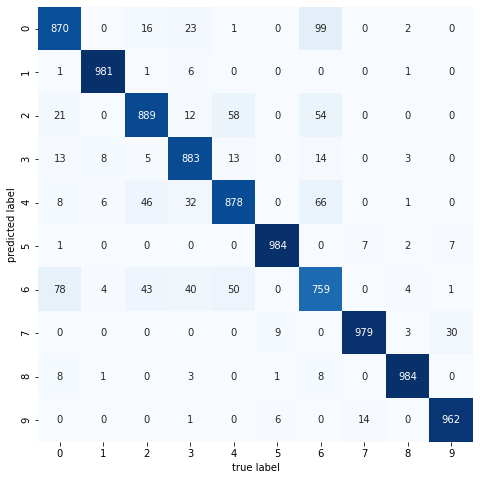

In [127]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Como es de esperarse, los errores de clasificación se encuentran principalmente entre categorías visualmente similares, como pueden ser la categoría 0 y 6 (T-shirt/top vs. Shirt), o entre 2, 4 y 6, a saber "pullover", "coat" y "dress", todas prendas con siluetas similares.

Ahora, miramos el autoencoder + MLP:
#### Autoencoder + MLP
Lo primero que hacemos es verificar que las imágenes hayan quedado bien reconstruidas.

In [129]:
test_autoencoder = autoencoder.predict(X_test[:10].reshape(-1, 28, 28, 1))

evaluation_autoencoder = autoencoder.evaluate(X_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Loss : {:.3f}'.format(evaluation_autoencoder))

313/313 [==============================] - 1s 2ms/step - loss: 0.0580
Test Loss : 0.058


Vemos que la pérdida en test es un poco más alta que en validación, pero sigue siendo bastante baja, lo cual da buenos indicios de nuestro modelo. Veamos si las imágenes están bien reconstruidas:

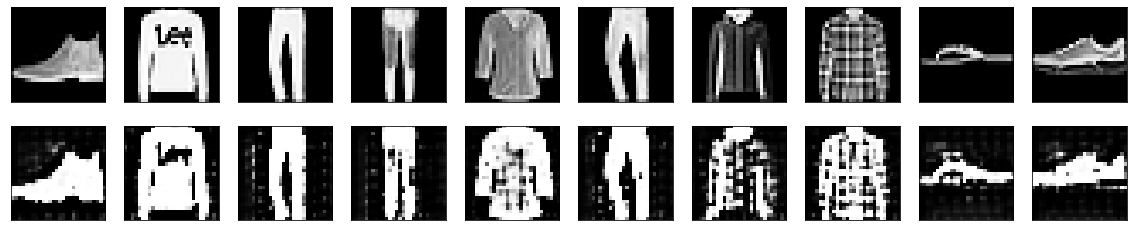

In [131]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test[:10], test_autoencoder], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Vemos que la reconstrucción de las imágenes es relativamente buena para esta muestra del conjunto de test. Claramente es mejor en validación, pero casi todas las imágenes pueden distinguirse entre sí.

Ahora, usamos el modelo clasificador con autoencoder previo que encontramos haciendo CV:

In [135]:
y_pred_autoencoder_mlp = best_model_mlp_autoencoder.predict(X_test.reshape(-1, 28, 28, 1))
y_pred_autoencoder_mlp = y_pred_autoencoder_mlp.argmax(1)

In [138]:
print('Reporte para el modelo entonado')
print(classification_report(y_test, y_pred_autoencoder_mlp))

Reporte para el modelo entonado
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1000
           1       1.00      0.94      0.97      1000
           2       0.79      0.80      0.79      1000
           3       0.86      0.89      0.87      1000
           4       0.82      0.78      0.80      1000
           5       0.99      0.88      0.93      1000
           6       0.65      0.74      0.69      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.91      0.98      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



Podemos ver que este modelo, en test, tiene una exactitud de 87%. Esto está bien, pues el de entrenamiento fue 89%, lo que indica que definitivamente no era un modelo con sobreajuste. Ahora, el primer modelo funcionó mejor (quizá por las capas de <code>maxpooling</code> que incluimos), pero este también da muy buenos resultados. Adelantándonos un poco a la matriz de confusión, podemos ver que, de todas formas, la diagonal sigue siendo la mejor clasificada.

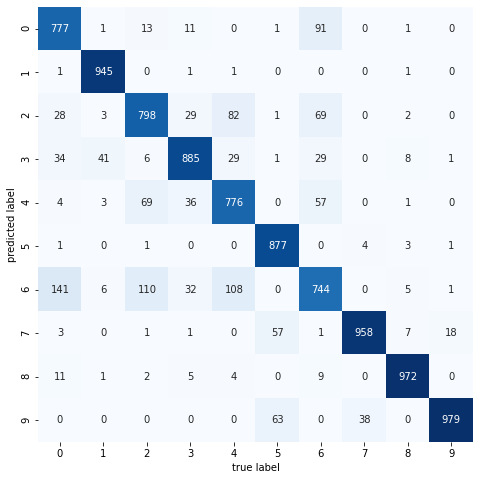

In [139]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred_autoencoder_mlp)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Como es de esperarse, los errores de clasificación se encuentran principalmente entre categorías visualmente similares, como pueden ser la categoría 0 y 6 (T-shirt/top vs. Shirt), o entre 2, 4 y 6, a saber "pullover", "coat" y "dress", todas prendas con siluetas similares.

Por último, desplegamos el modelo en el que usamos denoising en el autoencoder. Primero, aplicamos el ruido al conjunto de test y revisamos que las imágenes queden bien reconstruidas. Claramente, el parámetro de ruido es el mismo de train y validación, 0.2.

In [140]:
X_test_noise = noising_image(X_test, 0.2)

Vemos la reconstrucción de las 10 primeras imágenes:

In [143]:
predichas = denoising_autoencoder.predict(X_test_noise[:10].reshape(-1, 28, 28, 1))

evaluation_denoising = denoising_autoencoder.evaluate(X_test_noise.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Loss : {:.3f}'.format(evaluation_denoising))

313/313 [==============================] - 1s 2ms/step - loss: 0.0661
Test Loss : 0.066


Podemos ver que la pérdida es un poco mayor a validación. Veamos cómo se reconstruyen las imágenes:

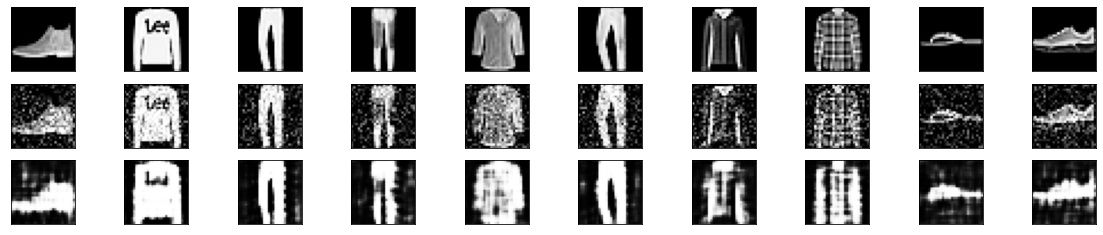

In [144]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test[:10], X_test_noise[:10], predichas], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Vemos que, con el ruido, especialmente las últimas dos imágenes de zapatos se hacen más difíciles de clasificar. Vamos a ver qué tal le va a nuestro modelo clasificador.

In [159]:
y_pred_denoising_autoencoder_mlp = best_model_mlp_autoencoder_denoising.predict(X_test_noise.reshape(-1, 28, 28, 1))
y_pred_denoising_autoencoder_mlp = y_pred_denoising_autoencoder_mlp.argmax(1)

In [164]:
print('Reporte para el modelo entonado')
print(classification_report(y_test, y_pred_denoising_autoencoder_mlp))

Reporte para el modelo entonado
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1000
           1       0.82      0.97      0.89      1000
           2       0.66      0.70      0.68      1000
           3       0.78      0.73      0.75      1000
           4       0.64      0.70      0.67      1000
           5       0.68      0.91      0.78      1000
           6       0.56      0.38      0.45      1000
           7       0.85      0.83      0.84      1000
           8       0.93      0.77      0.84      1000
           9       0.95      0.79      0.86      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000



Podemos ver que la exactitud de este modelo es del 76%. Un poco más mala que los otros dos modelos, claro está, seguro por la reducción de los datos que hicimos en train (y con lo cual entrenamos un modelo mucho menos robusto que los anteriores). No obstante, considerando que la exactitud de test fue 82%, 76% no es un mal resultado (no estamos haciendo overfitting, seguramente). Lo que sucede es que, desde entrenamiento, le están haciendo falta datos al modelo para aprender mejor. Si tuviésemos más datos en entrenamiento, seguramente este modelo tendría mejor exactitud.

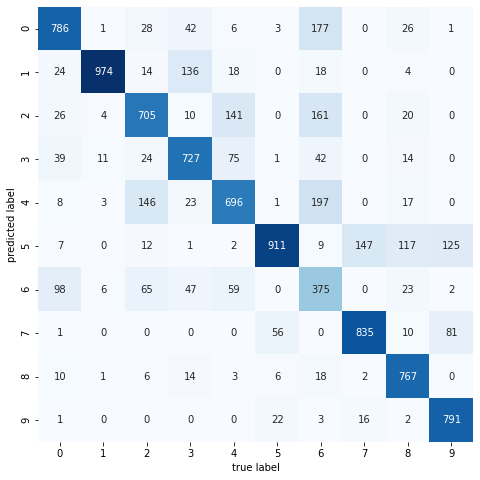

In [165]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred_denoising_autoencoder_mlp)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

En esta matriz podemos ver que, además del grupo de categorías donde esperamos error ("pullover", "coat" y "dress"), también hay otros errores mucho menos obvios, como la mezcla entre "trousers" y "dress", o la categoría de zapatos, que incluye la confusión entre "sandal", "sneaker" y "ankle boots", pero además incluye algo que se parece mucho menos: "bag".

## Referencias
[1] <a href='tensorflow.org/datasets/catalog/fashion_mnist'>Conjunto de datos Fashion MNIST</a>

[2] <a href='https://www.astesj.com/publications/ASTESJ_0601109.pdf'>Artículo: CNNs for Fashion-MNIST</a>

[3] http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf

[4] https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks

[5] https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

[6] https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

[7] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

[8] https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

[9] https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=1ShU787gZZg0

[10] http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz